In [1]:
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

from sklearn import cluster
import sklearn.metrics
from sklearn.metrics import adjusted_rand_score
from dateutil.relativedelta import relativedelta

In [2]:
df= pd.read_csv('projet5.csv')

In [3]:
rfm_df= pd.read_csv('rfm.csv')

In [4]:
df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,review_id,...,freight_value,payment_sequential,payment_type,payment_installments,payment_value,product_length_cm,product_category_name_english,seller_zip_code_prefix,seller_city,seller_state
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,...,8.72,1.0,credit_card,1.0,18.12,19.0,housewares,9350.0,maua,SP
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,...,8.72,3.0,voucher,1.0,2.00,19.0,housewares,9350.0,maua,SP
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,a54f0611adc9ed256b57ede6b6eb5114,...,8.72,2.0,voucher,1.0,18.59,19.0,housewares,9350.0,maua,SP
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,8d5266042046a06655c8db133d120ba5,...,22.76,1.0,boleto,1.0,141.46,19.0,perfumery,31570.0,belo horizonte,SP
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,e73b67b67587f7644d5bd1a52deb1b01,...,19.22,1.0,credit_card,3.0,179.12,24.0,auto,14840.0,guariba,SP


In [5]:
df.dtypes

order_id                          object
customer_id                       object
order_status                      object
order_purchase_timestamp          object
order_estimated_delivery_date     object
customer_unique_id                object
customer_zip_code_prefix           int64
customer_city                     object
customer_state                    object
review_id                         object
review_score                     float64
order_item_id                    float64
product_id                        object
seller_id                         object
price                            float64
freight_value                    float64
payment_sequential               float64
payment_type                      object
payment_installments             float64
payment_value                    float64
product_length_cm                float64
product_category_name_english     object
seller_zip_code_prefix           float64
seller_city                       object
seller_state    

In [6]:
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [7]:
print(df['order_purchase_timestamp'].max())
print(df['order_purchase_timestamp'].min())

2018-10-17 17:30:18
2016-09-04 21:15:19


In [8]:
rfm_df.head()

,Unnamed: 0,customer_unique_id,recency,frequency,monetary,cluster,review_score,payment_installments
0,0,0000366f3b9a7992bf8c76cfdf3221e2,613,1,141.90,1,5.0,8.0
1,1,0000b849f77a49e4a4ce2b2a4ca5be3f,610,1,27.19,1,4.0,1.0
2,2,0000f46a3911fa3c0805444483337064,187,1,86.22,4,3.0,8.0
3,3,0000f6ccb0745a6a4b88665a16c9f078,403,1,43.62,4,4.0,4.0
4,4,0004aac84e0df4da2b147fca70cf8255,436,1,196.89,4,5.0,6.0


In [9]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115608 entries, 0 to 115607
Data columns (total 8 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   Unnamed: 0            115608 non-null  int64  
 1   customer_unique_id    115608 non-null  object 
 2   recency               115608 non-null  int64  
 3   frequency             115608 non-null  int64  
 4   monetary              115608 non-null  float64
 5   cluster               115608 non-null  int64  
 6   review_score          115608 non-null  float64
 7   payment_installments  115608 non-null  float64
dtypes: float64(3), int64(4), object(1)
memory usage: 7.1+ MB


In [10]:
# Sélectionner les colonnes spécifiques que vous souhaitez récupérer
df_reduit = df[['order_purchase_timestamp','customer_unique_id']]
rfm_df_reduit= rfm_df[['customer_unique_id','recency','frequency','monetary']]

# Fusionner les deux DataFrames sur la colonne 'customer_unique_id'
rfm_df = rfm_df_reduit.merge(df_reduit, on='customer_unique_id', how='left')

# Afficher les premières lignes du DataFrame résultant pour vérifier
rfm_df.head()

,customer_unique_id,recency,frequency,monetary,order_purchase_timestamp
0,0000366f3b9a7992bf8c76cfdf3221e2,613,1,141.90,2018-05-10 10:56:27
1,0000b849f77a49e4a4ce2b2a4ca5be3f,610,1,27.19,2018-05-07 11:11:27
2,0000f46a3911fa3c0805444483337064,187,1,86.22,2017-03-10 21:05:03
3,0000f6ccb0745a6a4b88665a16c9f078,403,1,43.62,2017-10-12 20:29:41
4,0004aac84e0df4da2b147fca70cf8255,436,1,196.89,2017-11-14 19:45:42


In [11]:
rfm_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 210890 entries, 0 to 210889
Data columns (total 5 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   customer_unique_id        210890 non-null  object        
 1   recency                   210890 non-null  int64         
 2   frequency                 210890 non-null  int64         
 3   monetary                  210890 non-null  float64       
 4   order_purchase_timestamp  210890 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 9.7+ MB


In [12]:
# Indexation par la colonne id
rfm_df.set_index('customer_unique_id',inplace = True)

# stabilité à l'initialisation 

In [13]:

ari_score2 = []

# Initialisation des centroids aléatoirement
kmeans_init2 = KMeans(init='k-means++', n_clusters=5, n_init=5, max_iter= 100)


for _ in range(10):  # Faire 10 fois pour évaluer la stabilité de l'initialisation
    # Création des datasets par périodes
    data_period2 = rfm_df.copy()

    # Sélection des colonnes pour le clustering
    clustering_data2 = data_period2.drop(columns=['order_purchase_timestamp'])

    # K-Means avec l'initialisation aléatoire
    kmeans_p2 = Pipeline([("preprocessor", StandardScaler()), ("kmeans", kmeans_init2)])
    kmeans_p2.fit(clustering_data2)
    p_labels2 = kmeans_p2.named_steps['kmeans'].labels_

    # Calcul des ARI score avec l'initialisation aléatoire
    ari = adjusted_rand_score(kmeans_init2.labels_, p_labels2)
    if isinstance(ari, float):
        ari_score2.append(ari)
        print("ARI score obtenu:", ari)
    else:
        print("ARI score n'est pas un float:", ari)

# Calcul de la moyenne des ARI score pour évaluer la stabilité de l'initialisation
if ari_score2:
    average_ari = sum(ari_score2) / len(ari_score2)
    print("Stabilité de l'initialisation du K-Means (moyenne des ARI):", average_ari)
else:
    print("Aucun score ARI valide n'a été obtenu.")


ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
ARI score obtenu: 1.0
Stabilité de l'initialisation du K-Means (moyenne des ARI): 1.0


# stabilté temporelle

In [14]:
print(rfm_df['order_purchase_timestamp'].max())
print(rfm_df['order_purchase_timestamp'].min())

2018-10-16 20:16:02
2016-09-04 21:15:19


In [15]:
# Periode initiale
start_date = dt.datetime(2017, 1, 1, 0, 0)
start_T0 = dt.datetime(2018, 1, 1, 0, 0)
mask_F0 = (rfm_df['order_purchase_timestamp'] > start_date) & (
    rfm_df['order_purchase_timestamp'] <= start_T0)
data_init = rfm_df.loc[mask_F0].drop(columns='order_purchase_timestamp')

# Créer le pipeline avec le préprocesseur StandardScaler et le modèle KMeans
kmeans_init = Pipeline([
    ("preprocessor", StandardScaler()),
    ("kmeans", KMeans(init='k-means++', n_clusters=5, n_init=5, max_iter= 100,random_state=19))
])

# Adapter le pipeline aux données
kmeans_init.fit(data_init)

# Obtenir les étiquettes de cluster attribuées à chaque individu
init_labels = kmeans_init.named_steps['kmeans'].labels_

In [16]:
ari_score = []

for p in range(1, 48):
    # Création des datasets par périodes
    start_date = dt.datetime(2017, 1, 1, 0, 0)
    start_T0 = dt.datetime(2018, 1, 1, 0, 0)
    start_date_Tp = start_T0 + relativedelta(days=+7*p)  # Incrémentation de 15 jours
    data_period = rfm_df.copy()
    mask_data_period = (rfm_df['order_purchase_timestamp'] > start_date) & (
        rfm_df['order_purchase_timestamp'] <= start_date_Tp)
    data_period = rfm_df.loc[mask_data_period].drop(
        columns='order_purchase_timestamp')

    # K-Means
    kmeans_p = Pipeline([("preprocessor", StandardScaler()),
                         ("kmeans", KMeans(init='k-means++', n_clusters=5, n_init=5, max_iter= 100,random_state=19))])
    kmeans_p.fit(data_period)
    p_labels = kmeans_p.named_steps['kmeans'].labels_

    # Calcul des ARI score
    ari_p = adjusted_rand_score(kmeans_init.predict(
        data_period), kmeans_p.predict(data_period))
    ari_score.append([p, ari_p])


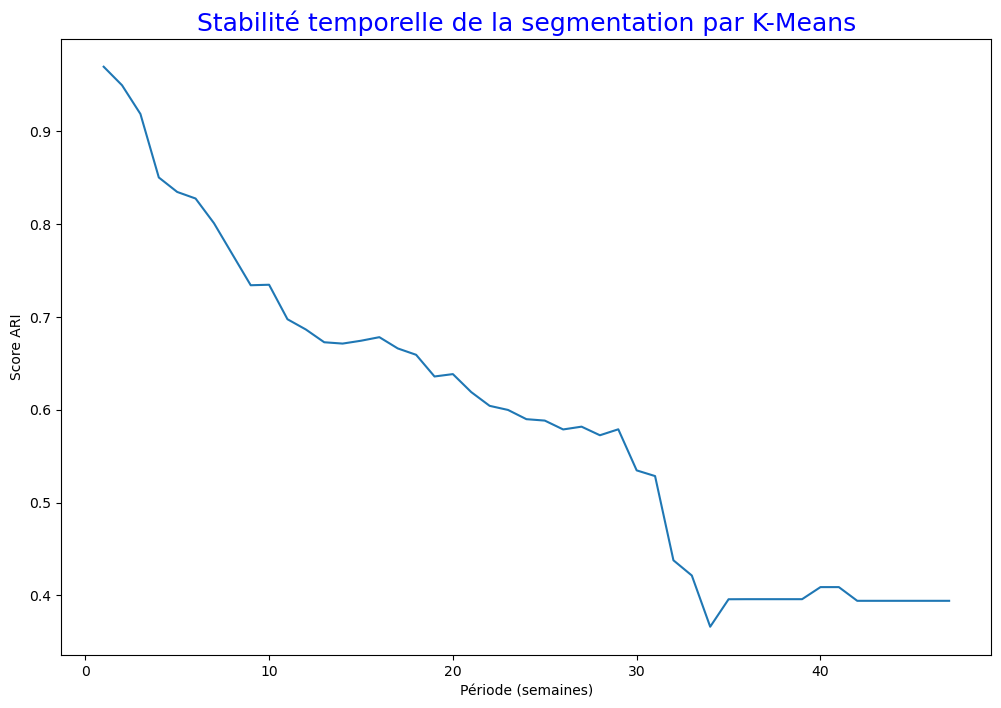

In [17]:
ari_score = pd.DataFrame(ari_score, columns=["periode", "ARI"])

# plot ARI Score
fig = plt.figure(figsize=(12, 8))
sns.lineplot(data=ari_score, x="periode", y="ARI")
plt.xlabel("Période (semaines)")
plt.ylabel("Score ARI")
plt.title("Stabilité temporelle de la segmentation par K-Means",
          fontsize=18,
          color="b")
plt.show()

# Test Kolmogorov-Smirnov

Le test de Kolmogorov-Smirnov est une méthode statistique utilisée pour comparer deux ensembles de données afin de déterminer s'ils proviennent de la même distribution. Il mesure la différence maximale entre les fonctions de répartition empiriques des deux ensembles de données. Si cette différence est significative (avec une valeur p inférieure à un seuil spécifié, souvent 0,05), on conclut que les ensembles de données ont des distributions différentes. Sinon, on suppose qu'ils proviennent de la même distribution. En résumé, le test de Kolmogorov-Smirnov aide à évaluer la similitude ou la différence entre deux distributions de données.

In [18]:
import pandas as pd
from scipy.stats import ks_2samp

features = rfm_df.columns[:-1]

# Créer une fonction pour diviser les données en semaines
def divide_into_weeks(data, start_date, end_date):
    # Convertisser les colonnes de dates en type datetime si ce n'est pas déjà fait
    data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
    
    # Créer une série de dates hebdomadaires entre start_date et end_date
    weekly_dates = pd.date_range(start=start_date, end=end_date, freq='W')
    
    # Initialiser une liste pour stocker les données de chaque semaine
    weekly_data = []
    
    # Diviser les données en semaines et stocker-les dans la liste weekly_data
    for i in range(len(weekly_dates)-1):
        start_week = weekly_dates[i]
        end_week = weekly_dates[i+1]
        weekly_data.append(data[(data['order_purchase_timestamp'] >= start_week) & 
                                (data['order_purchase_timestamp'] < end_week)])
    
    return weekly_data

# Diviser les données en semaines pour les deux périodes de temps
weekly_data_T0 = divide_into_weeks(rfm_df, start_date, start_T0)

# Initialiser une liste pour stocker les résultats du test pour chaque semaine
results = []

# Pour chaque semaine, appliquez le test de Kolmogorov-Smirnov et stockez le résultat
for i, weekly_data in enumerate(weekly_data_T0):
    ks_results = []
    for feature in features:
        ks_statistic, p_value = ks_2samp(weekly_data[feature], weekly_data[feature])
        ks_results.append((feature, ks_statistic, p_value))
    results.append((f'Semaine {i+1}', ks_results))

# Afficher les résultats
for week, ks_results in results:
    print(f"Résultats pour la semaine {week}:")
    for feature, ks_statistic, p_value in ks_results:
        if p_value < 0.05:
            print("   Les distributions de", feature, "sont différentes entre les deux périodes de temps.")
        else:
            print("   Les distributions de", feature, "sont similaires entre les deux périodes de temps.")



Résultats pour la semaine Semaine 1:
   Les distributions de recency sont similaires entre les deux périodes de temps.
   Les distributions de frequency sont similaires entre les deux périodes de temps.
   Les distributions de monetary sont similaires entre les deux périodes de temps.
Résultats pour la semaine Semaine 2:
   Les distributions de recency sont similaires entre les deux périodes de temps.
   Les distributions de frequency sont similaires entre les deux périodes de temps.
   Les distributions de monetary sont similaires entre les deux périodes de temps.
Résultats pour la semaine Semaine 3:
   Les distributions de recency sont similaires entre les deux périodes de temps.
   Les distributions de frequency sont similaires entre les deux périodes de temps.
   Les distributions de monetary sont similaires entre les deux périodes de temps.
Résultats pour la semaine Semaine 4:
   Les distributions de recency sont similaires entre les deux périodes de temps.
   Les distributions de

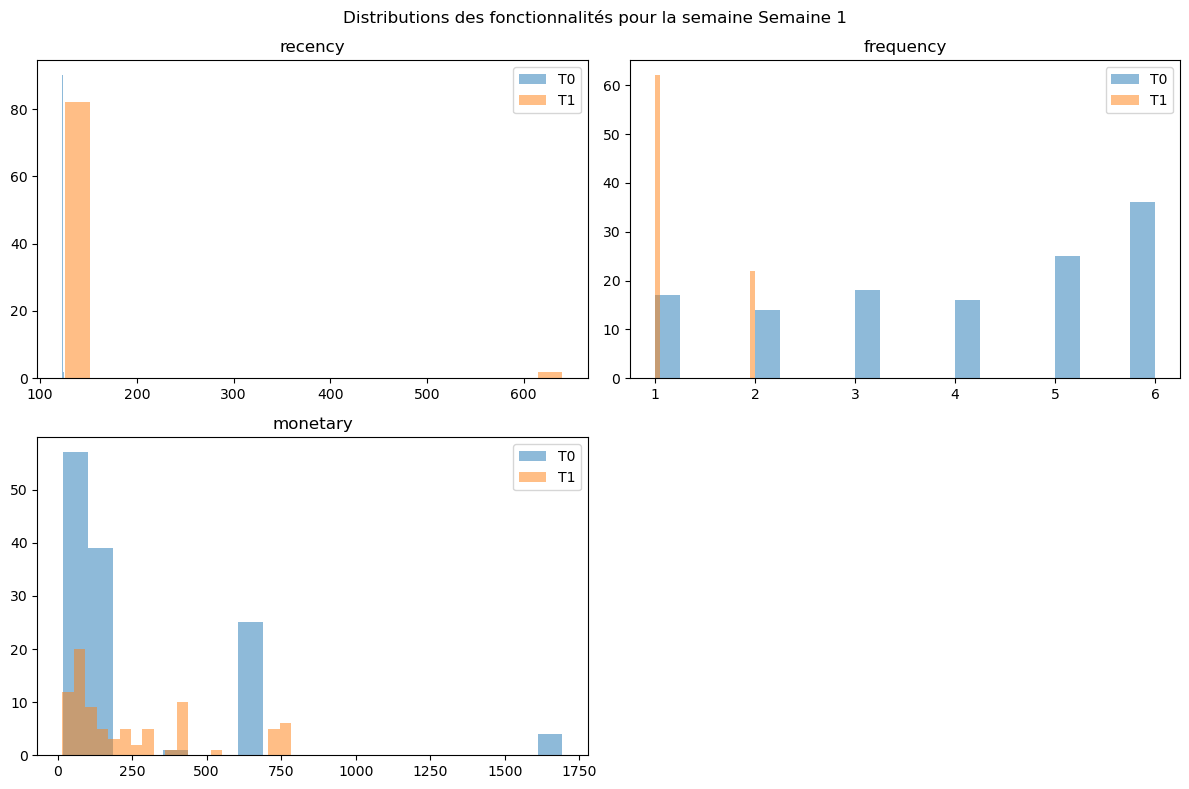

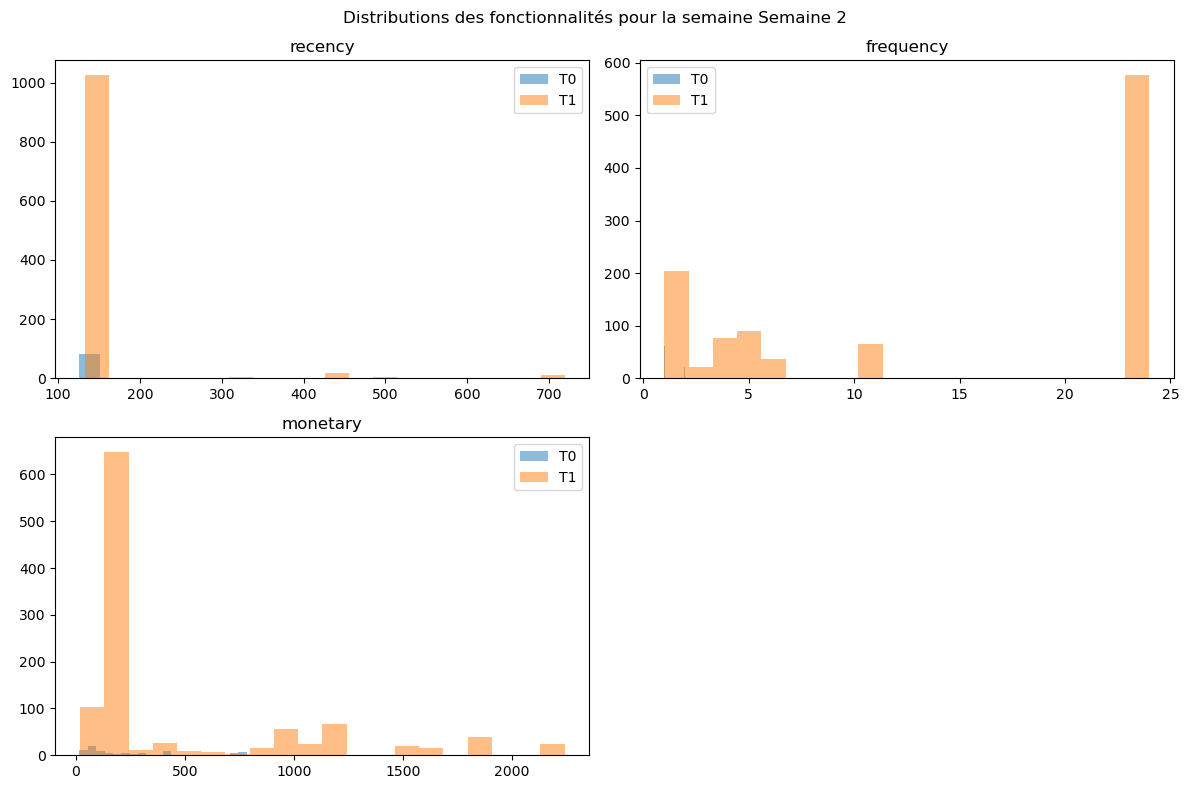

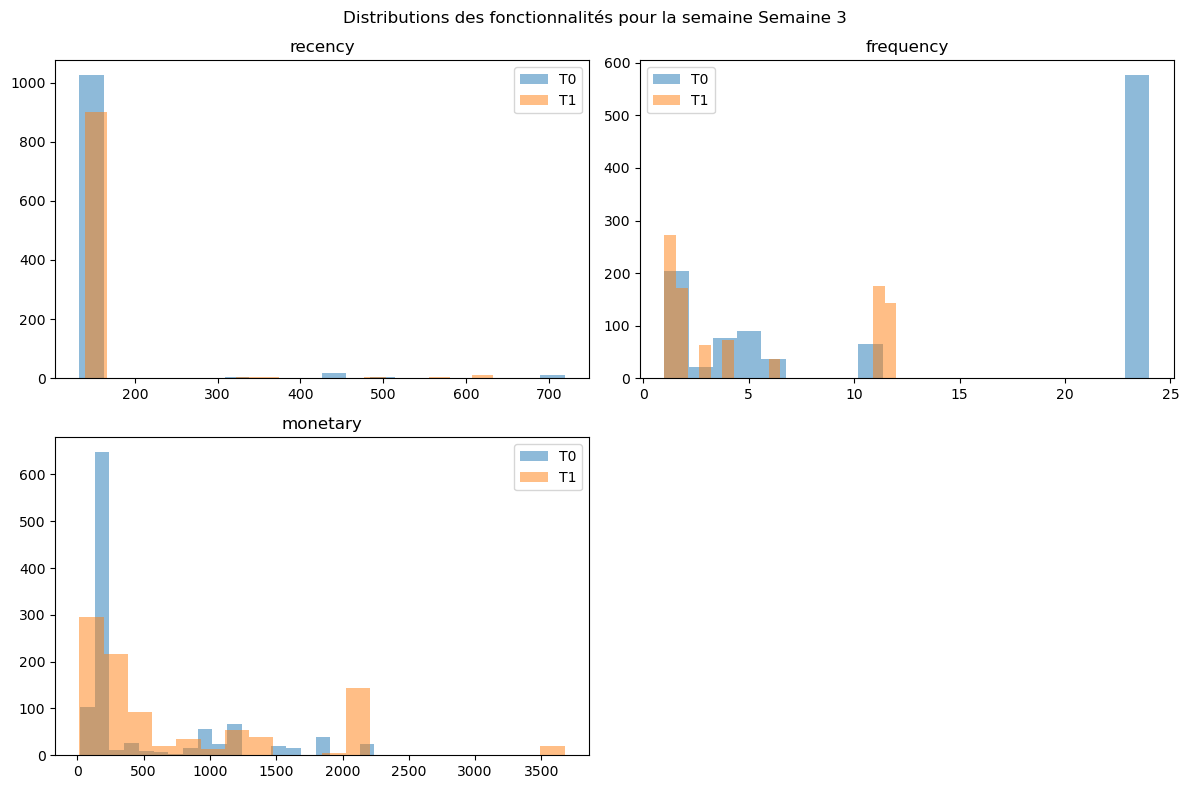

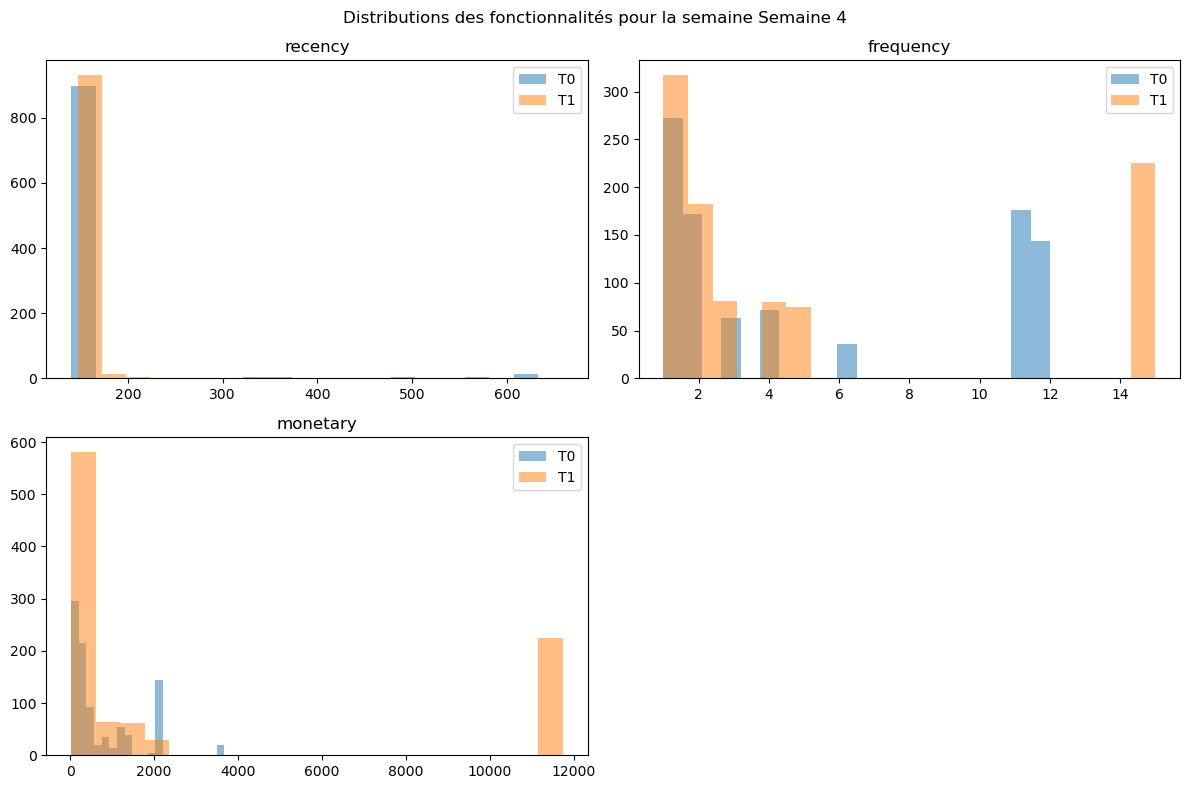

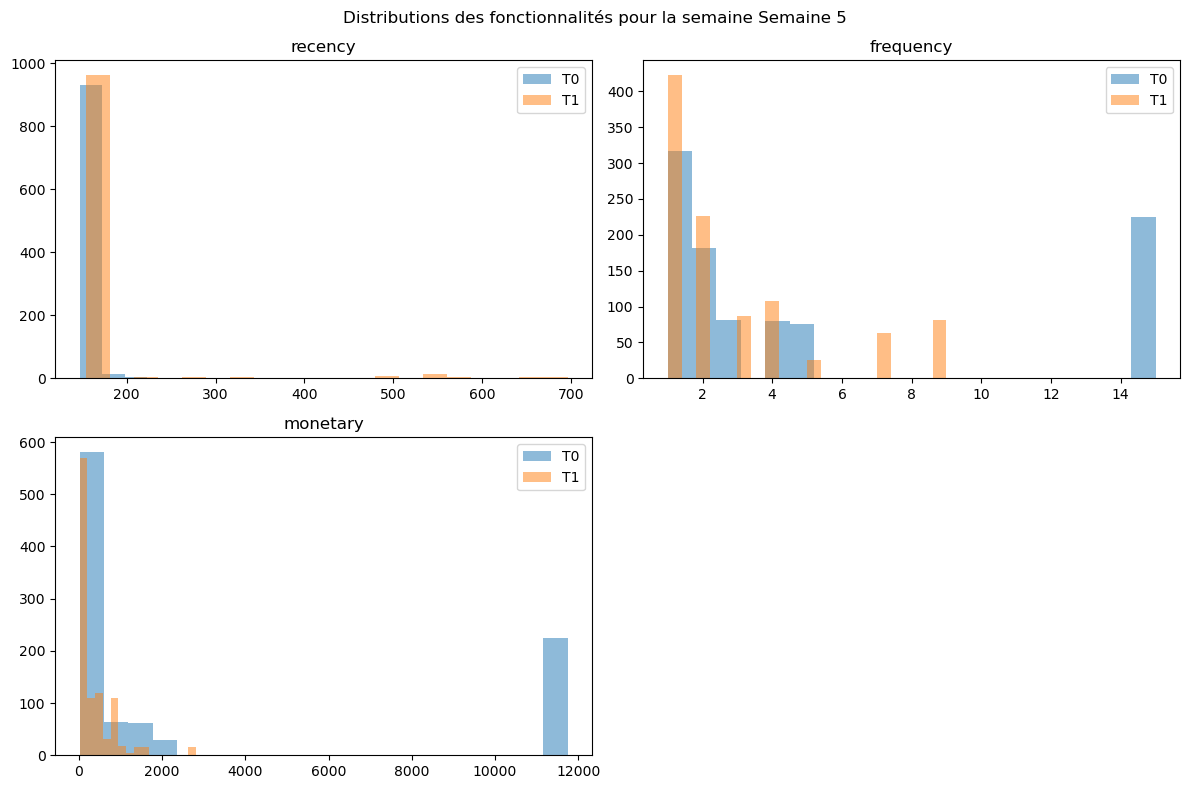

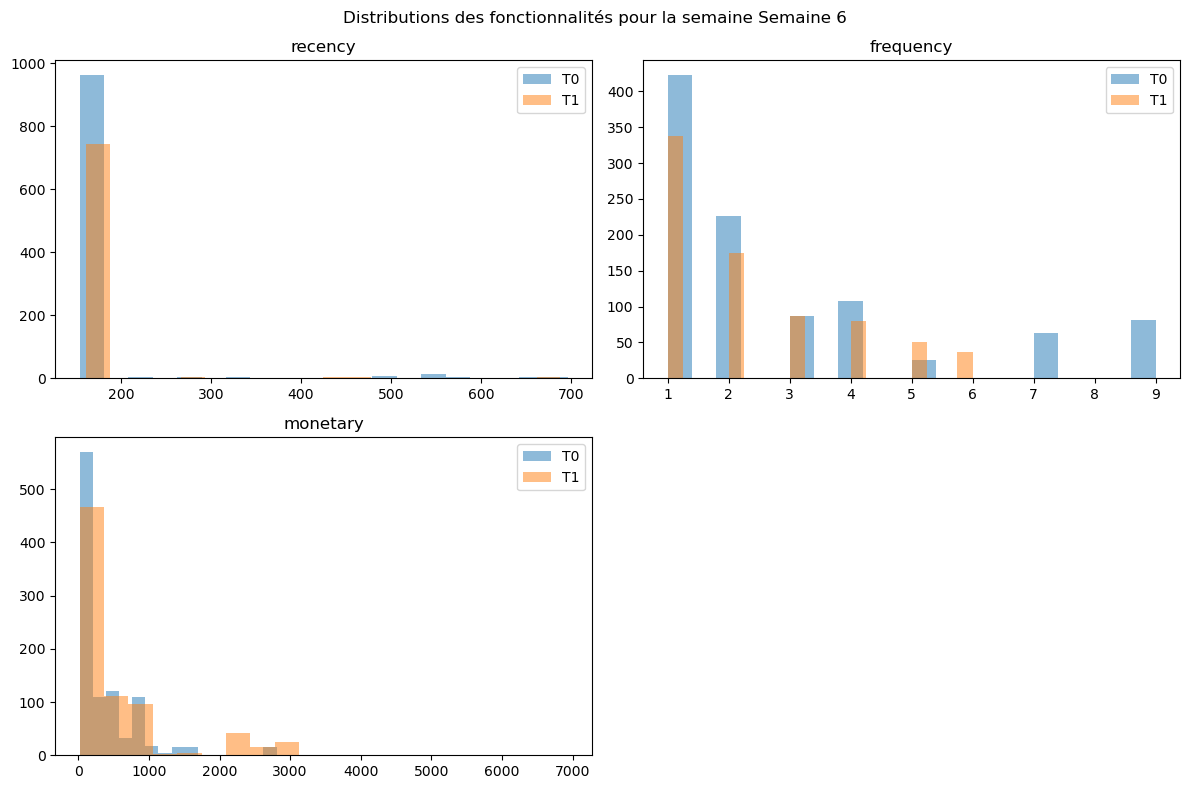

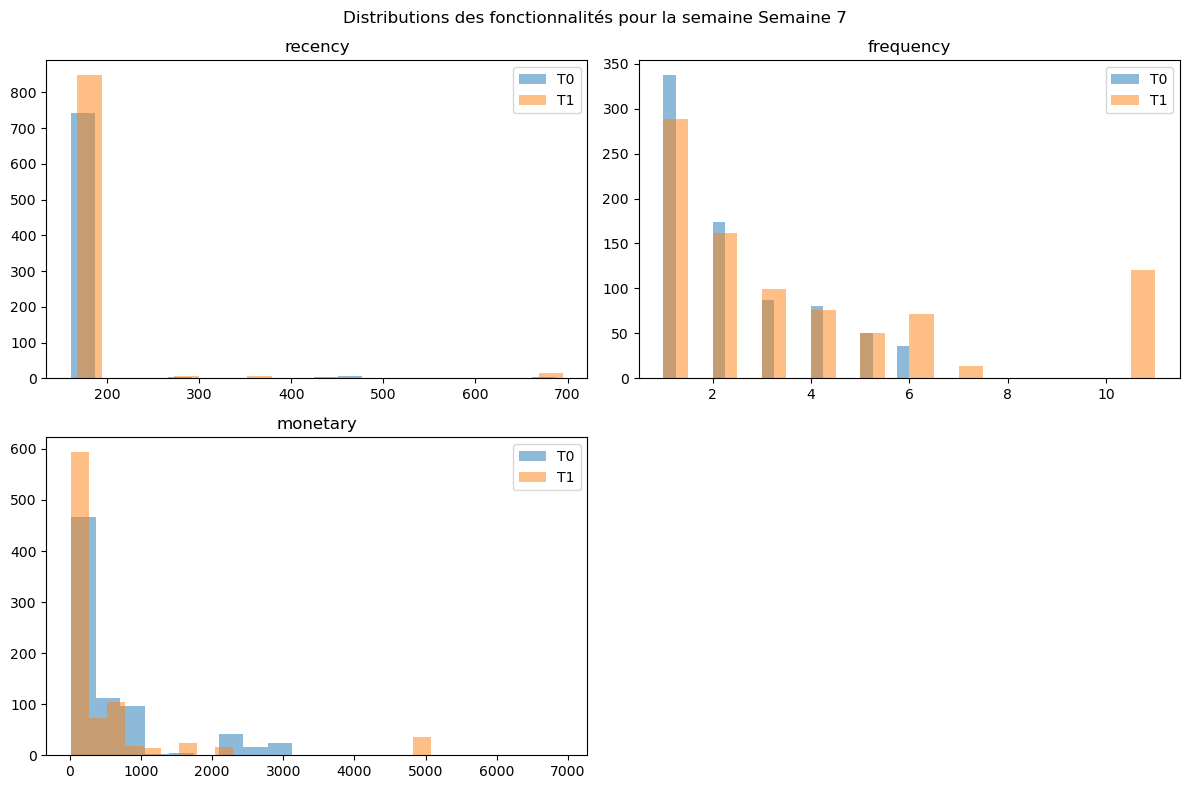

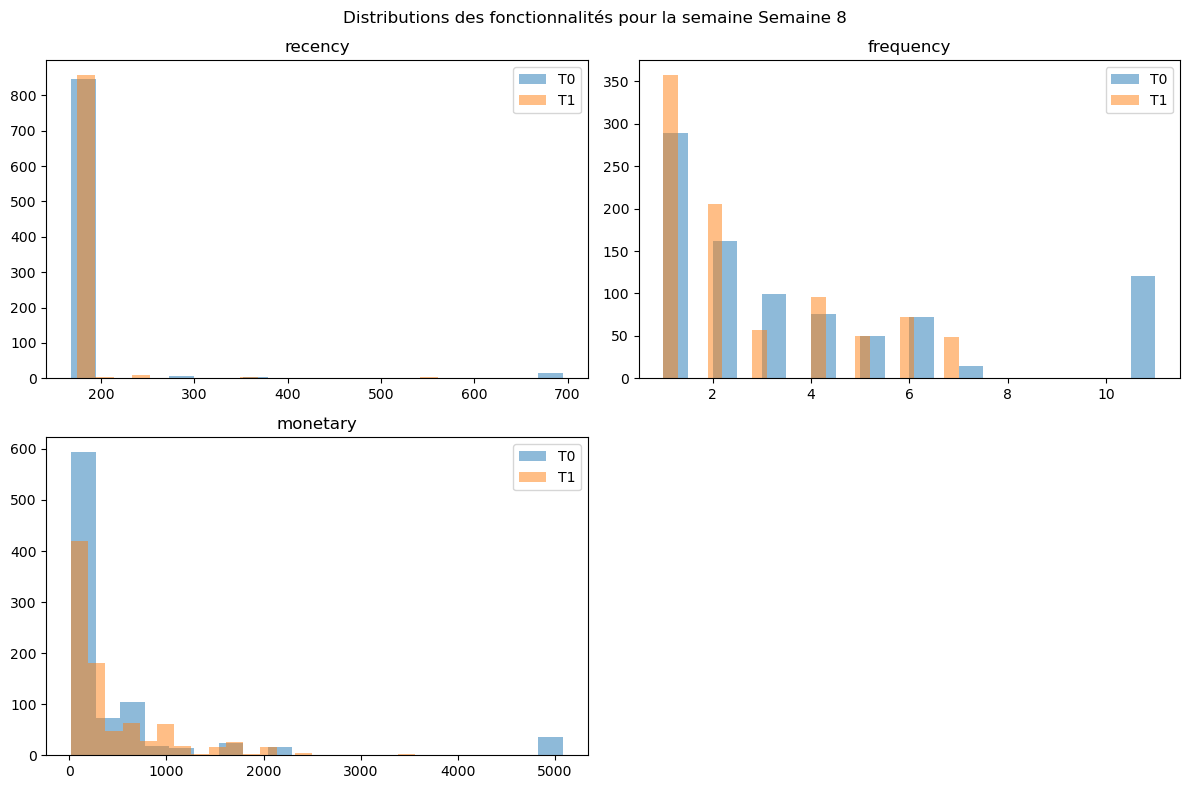

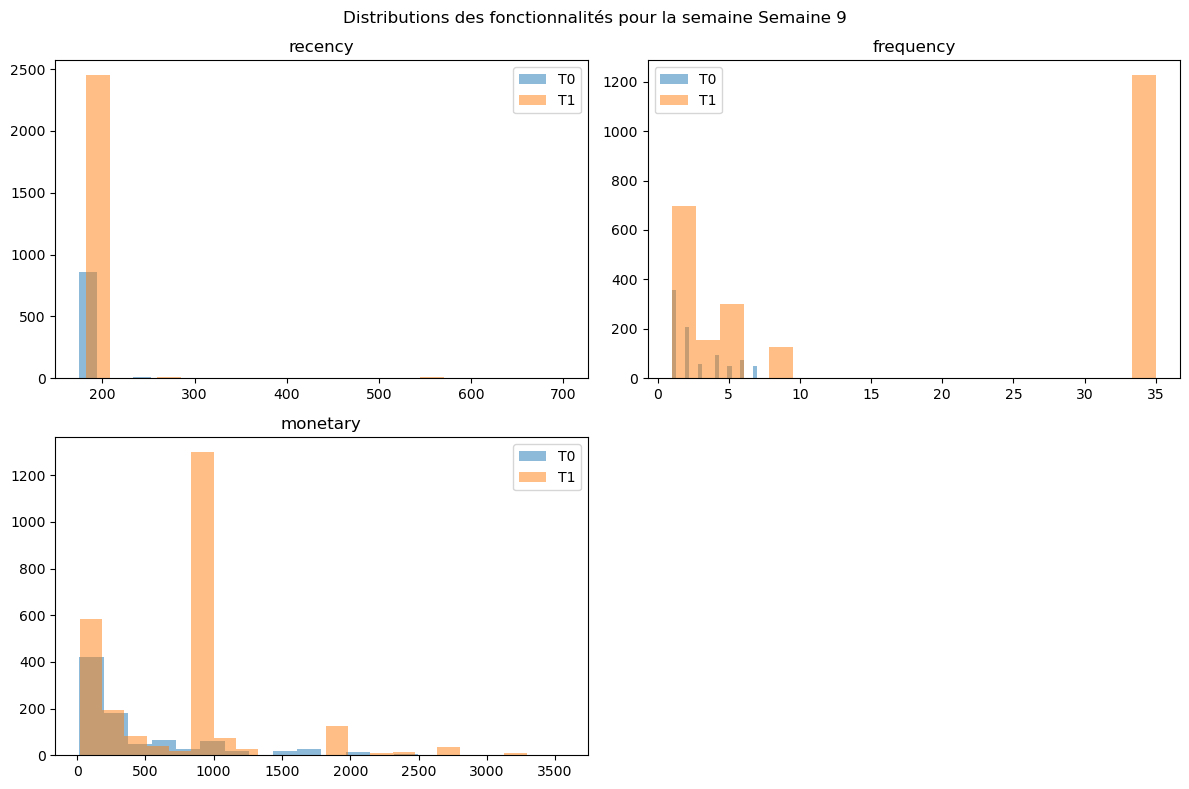

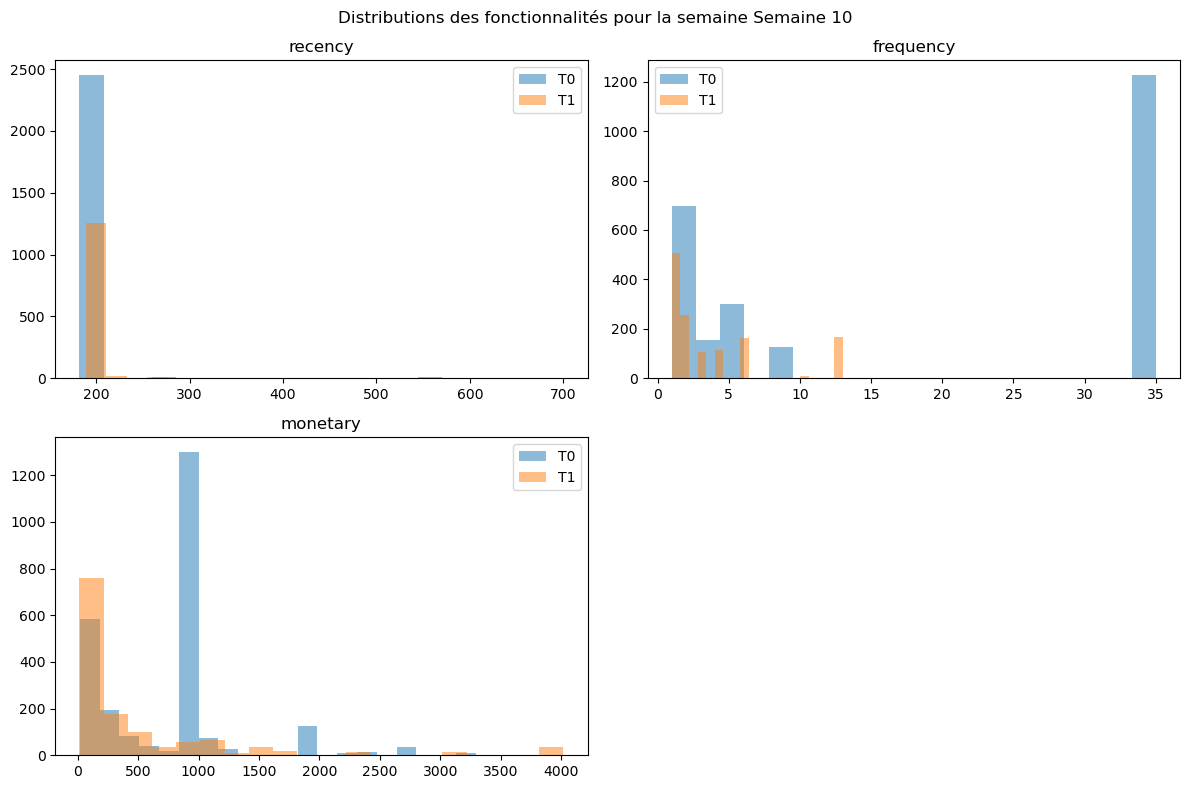

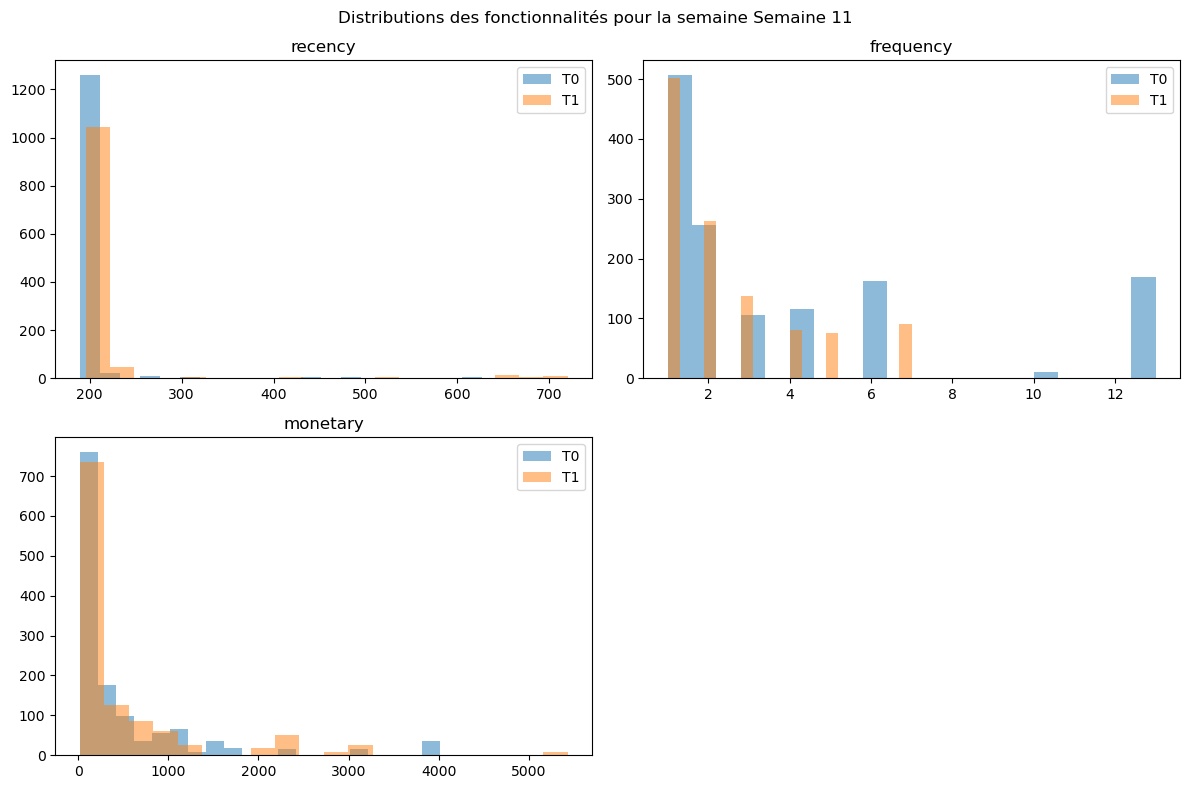

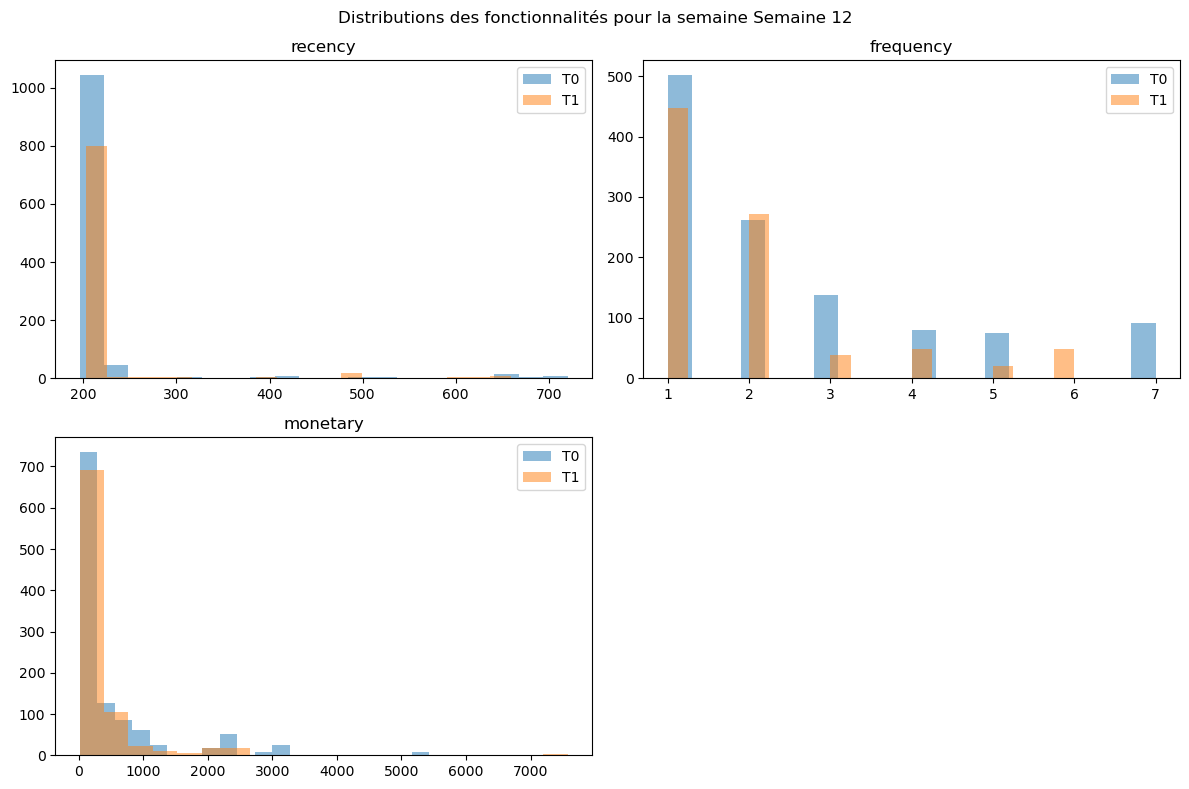

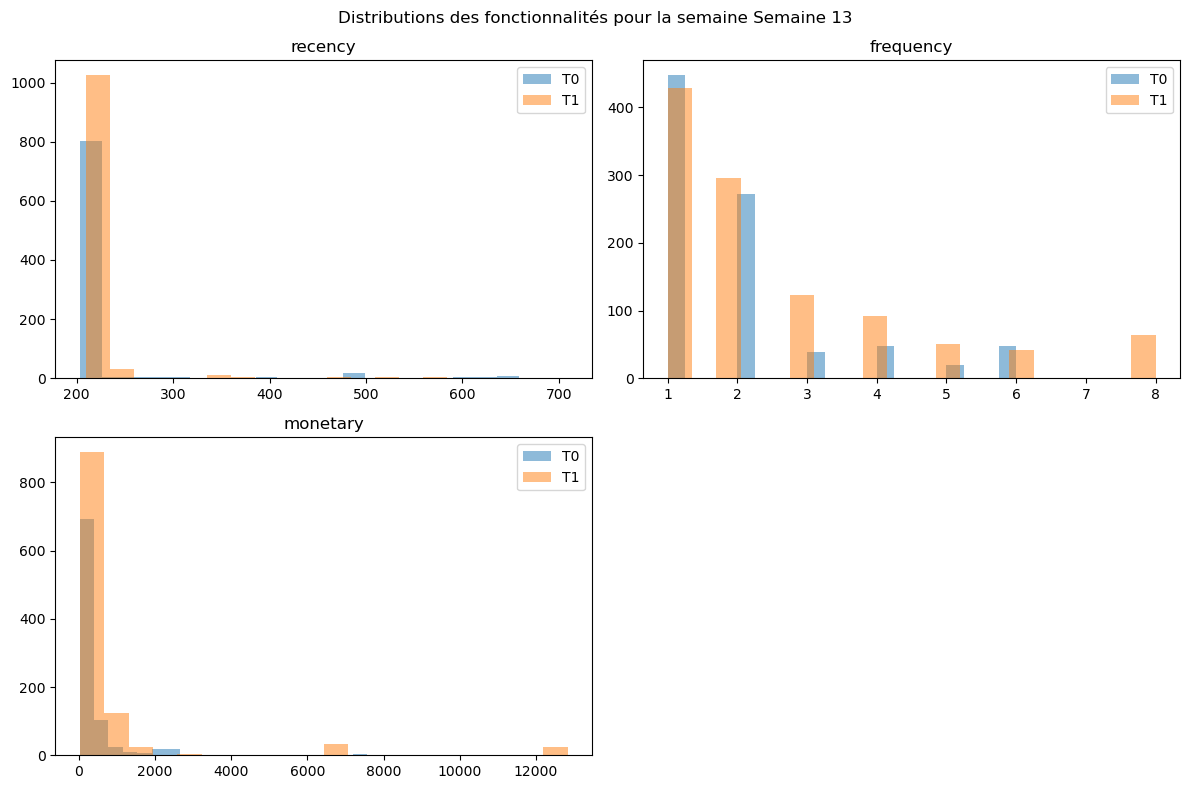

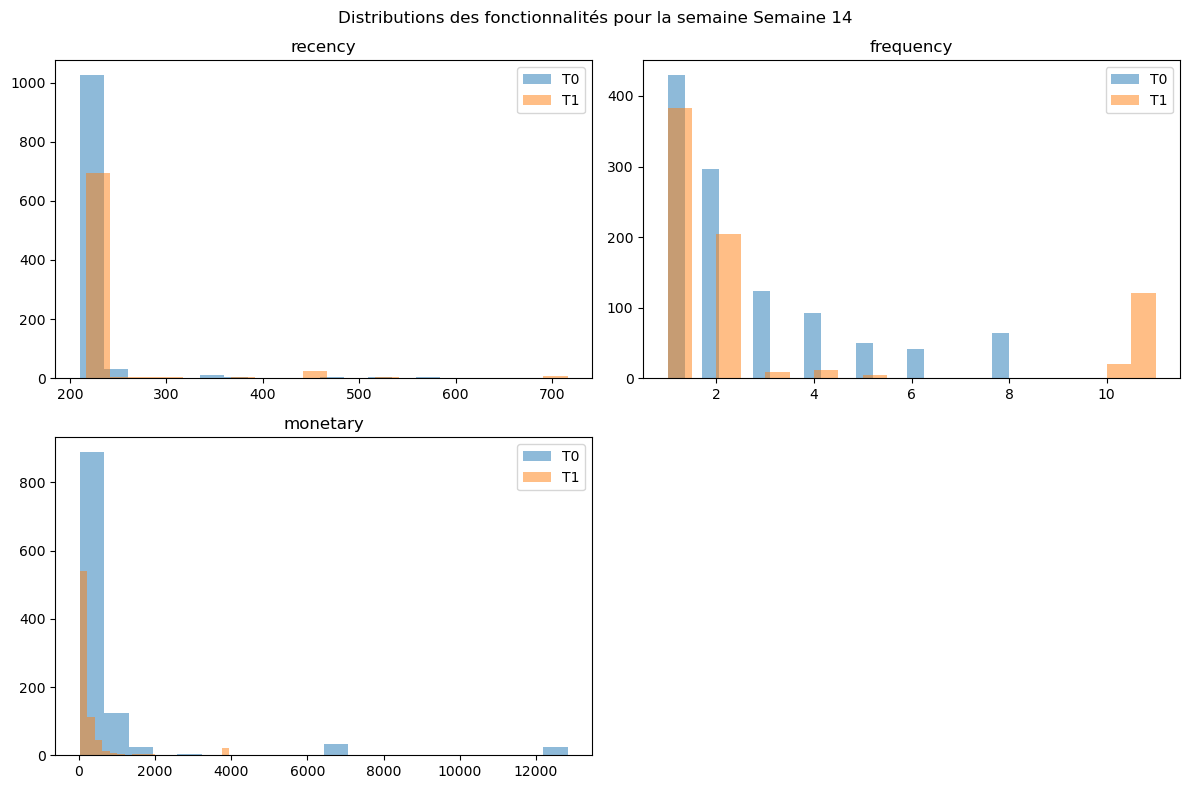

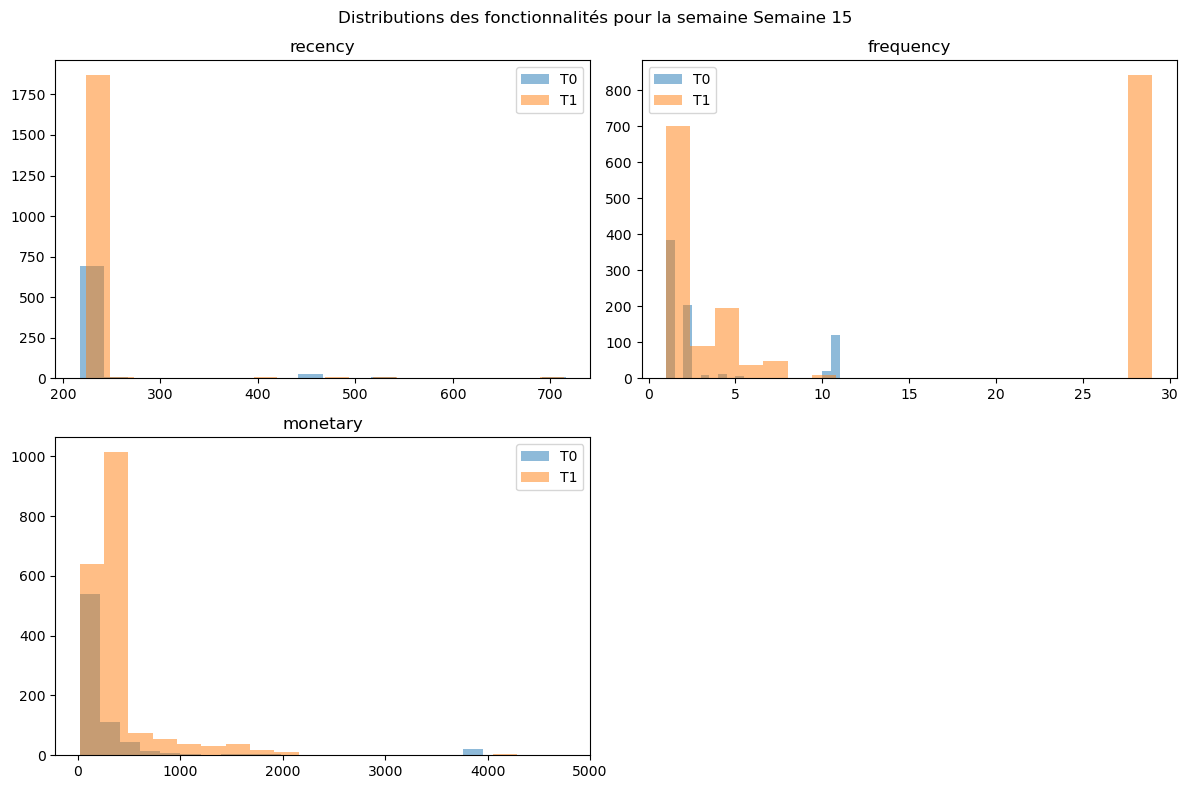

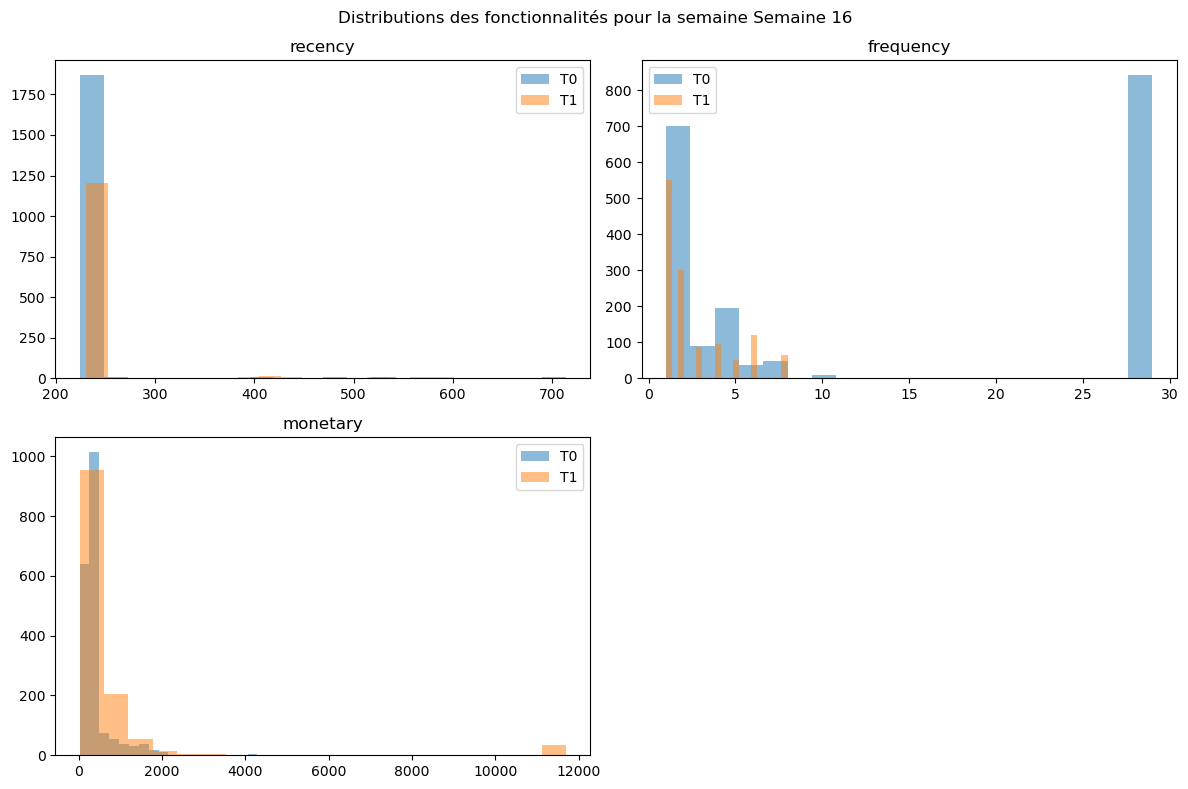

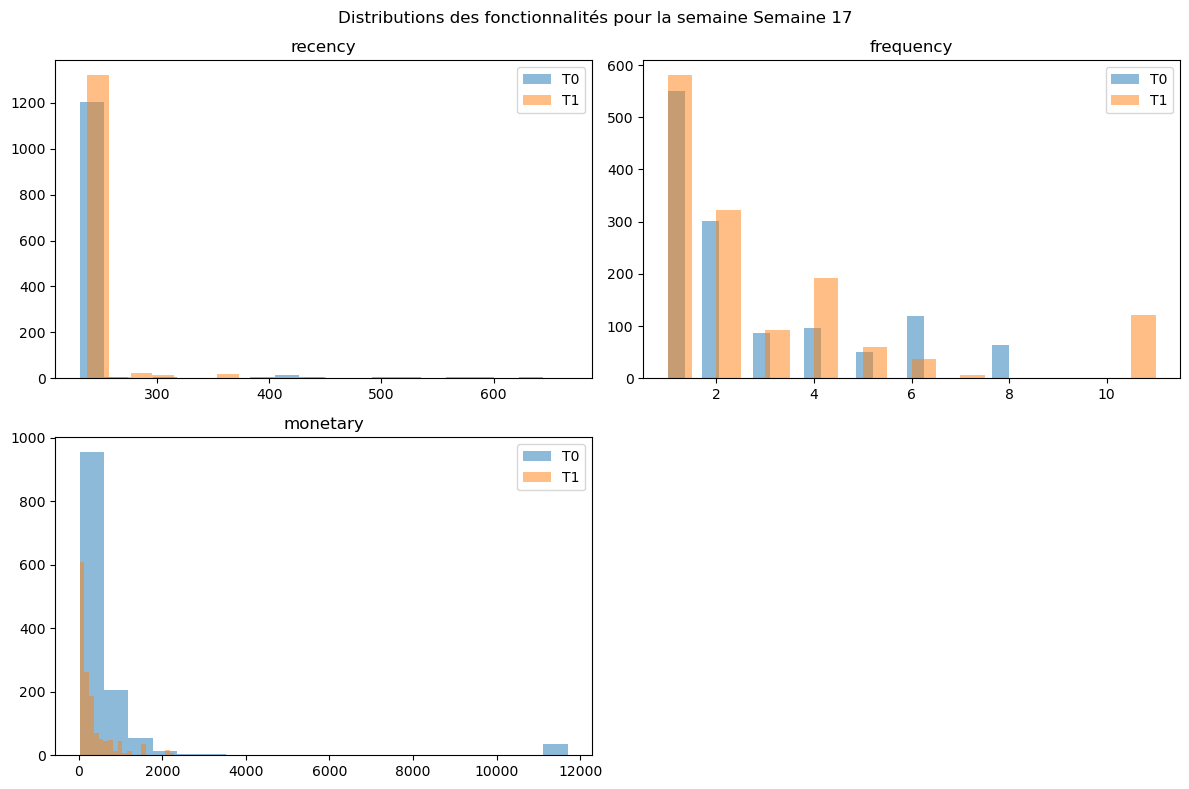

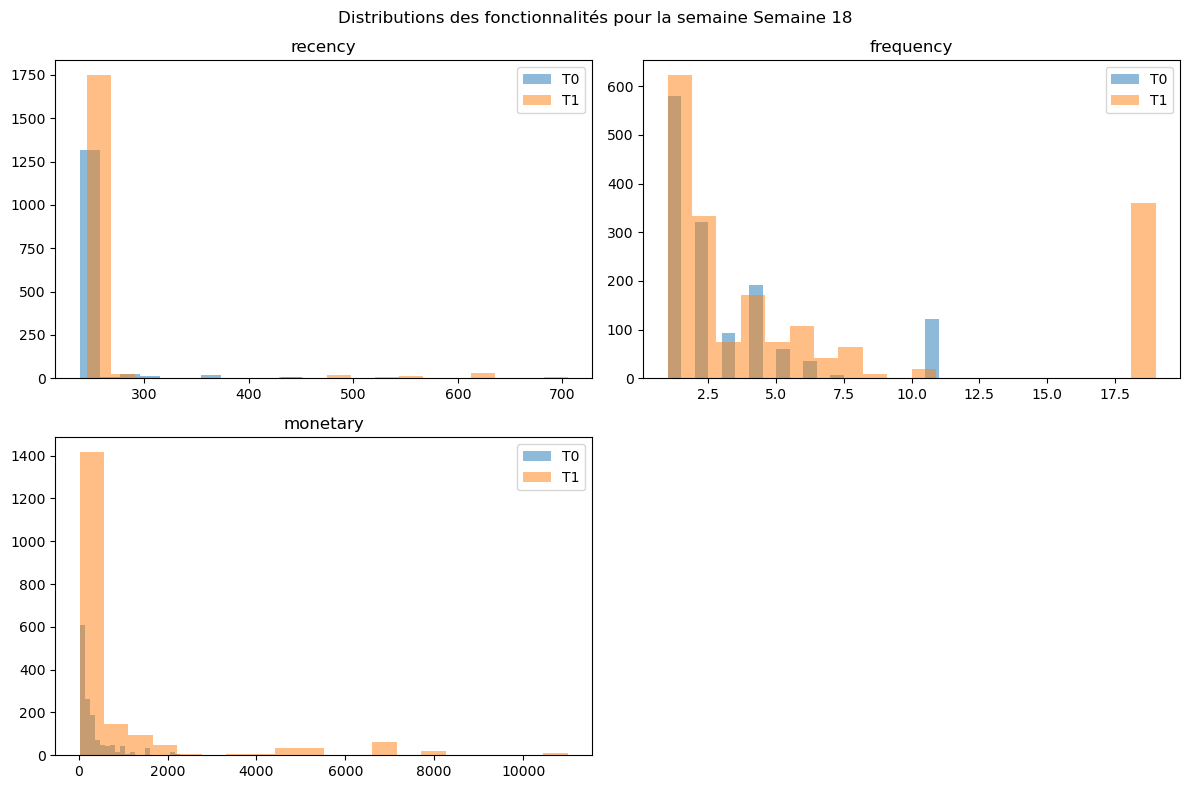

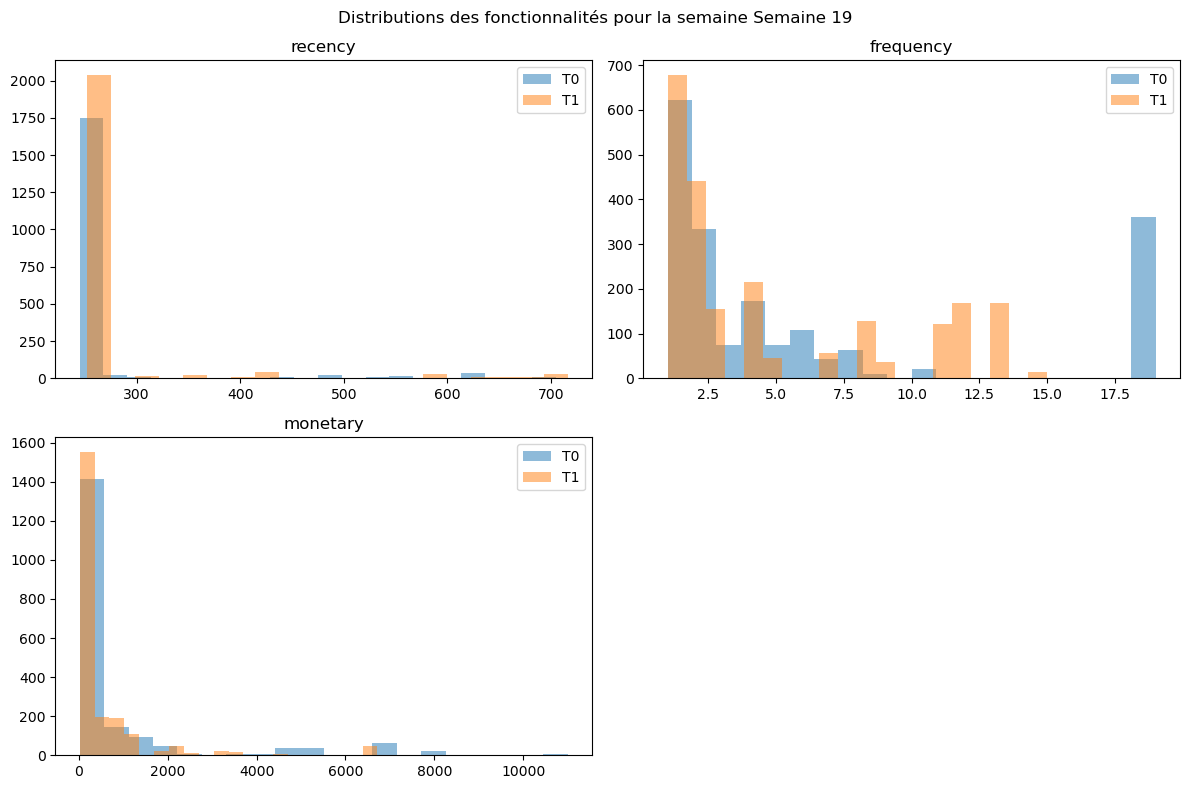

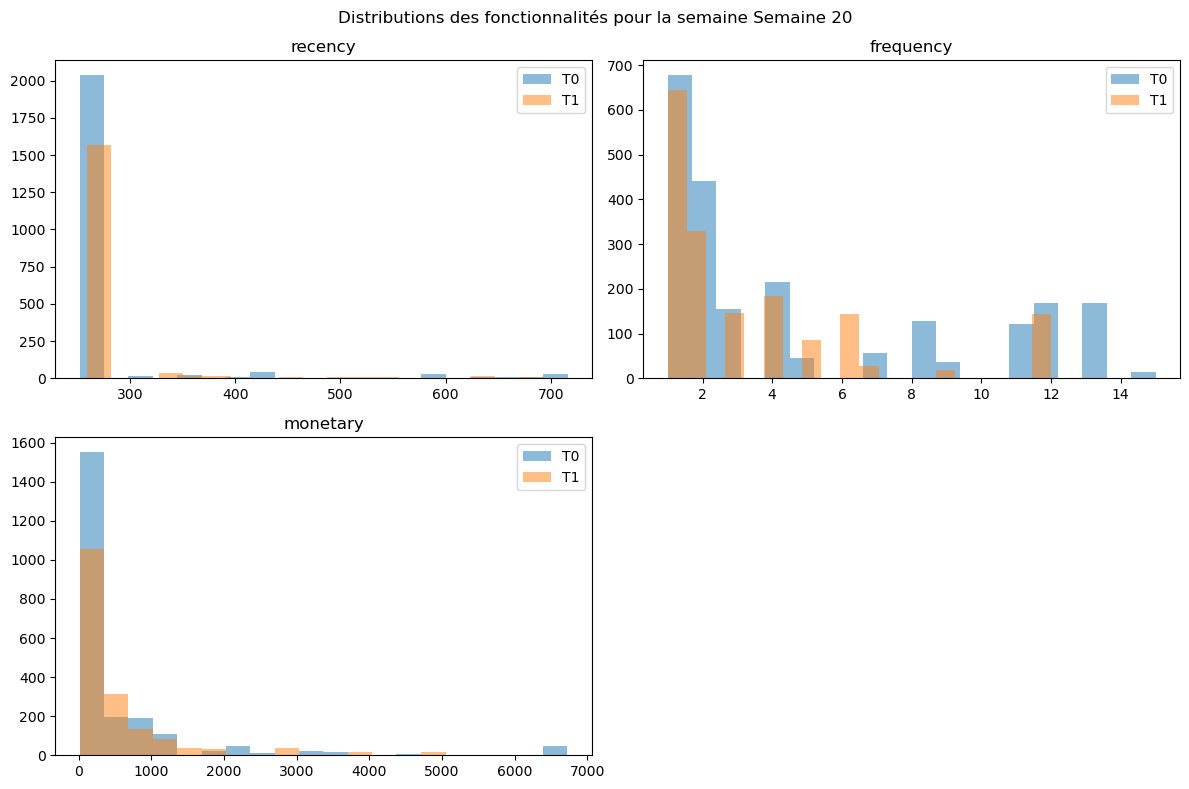

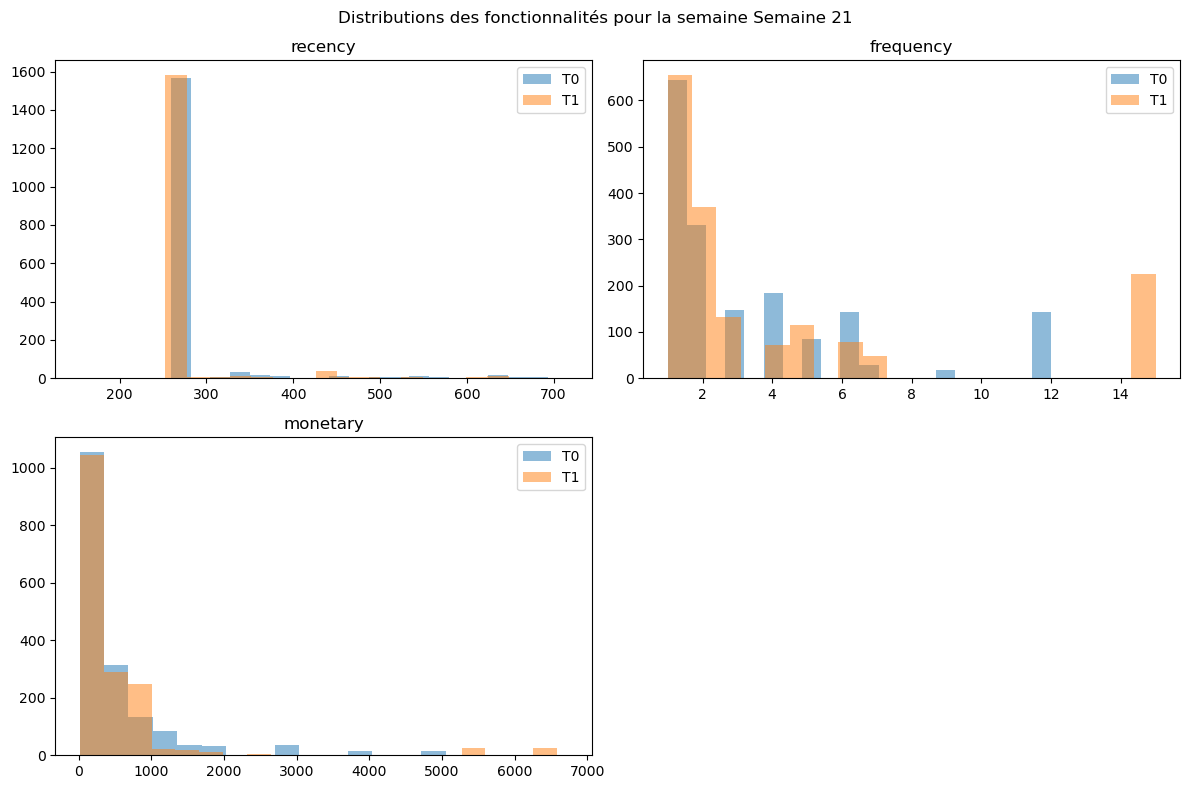

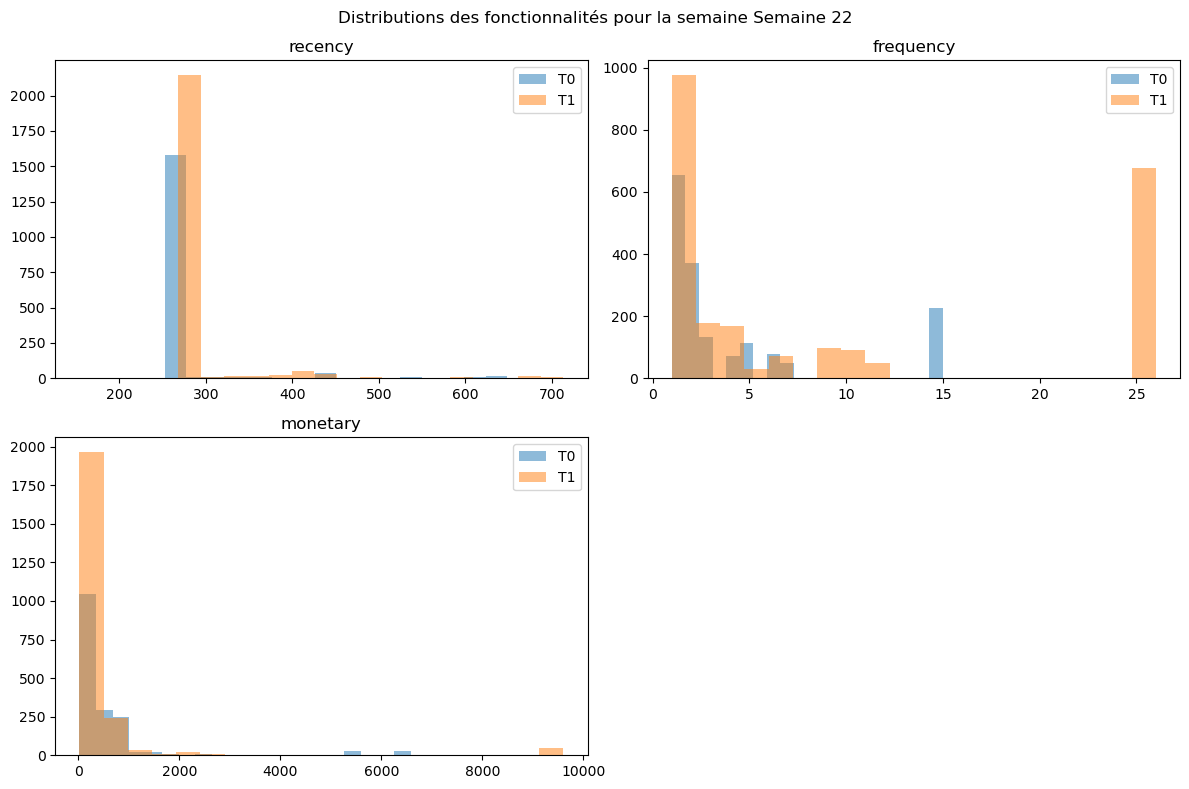

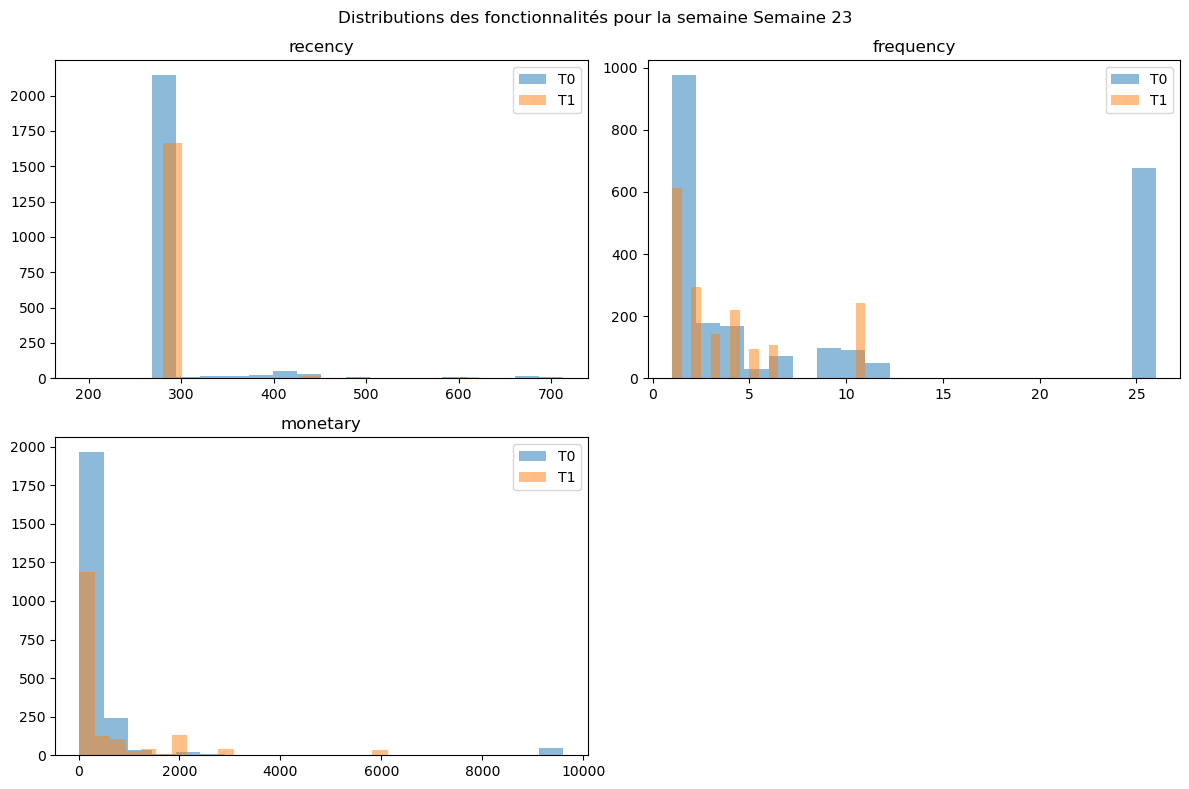

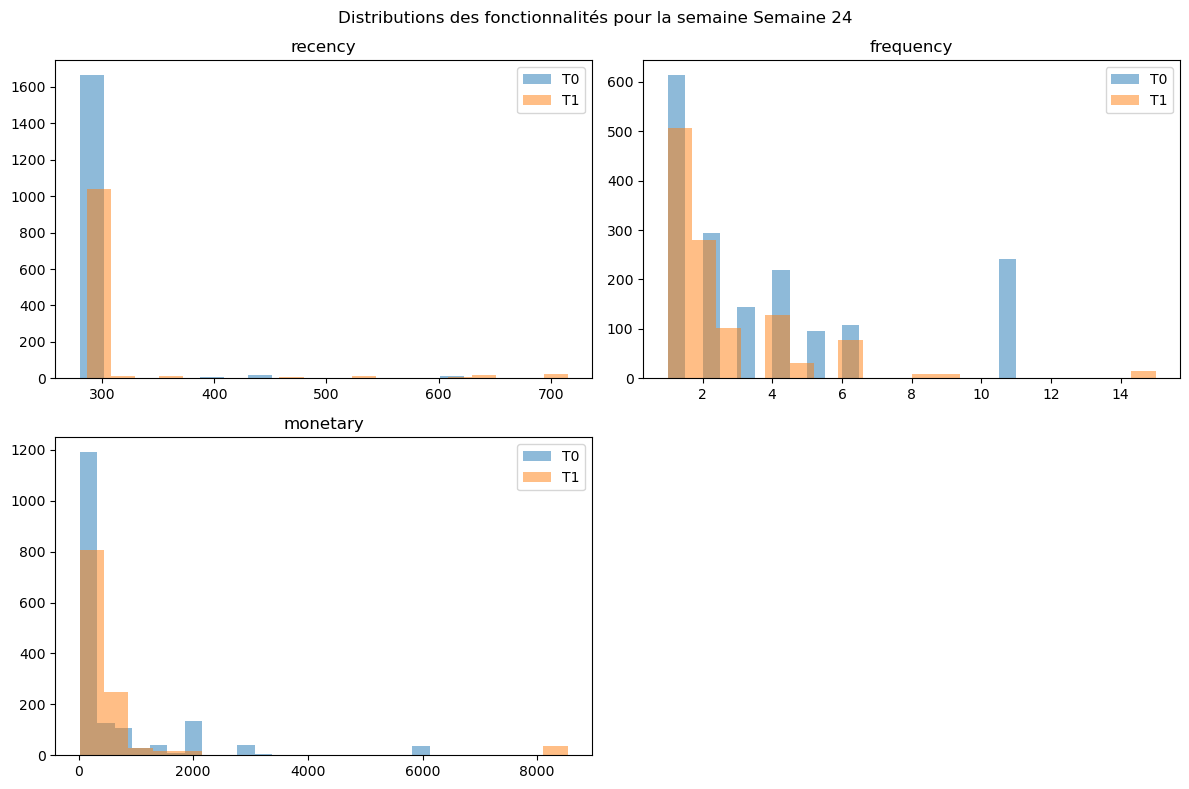

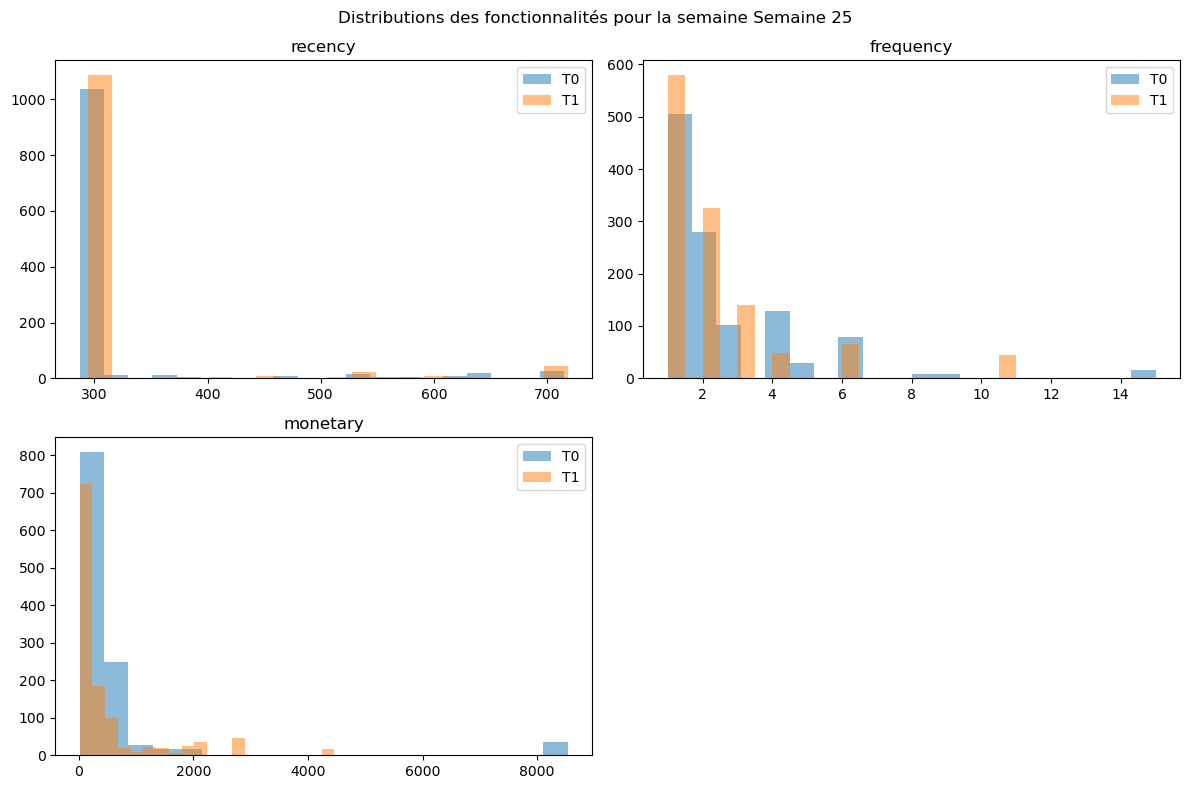

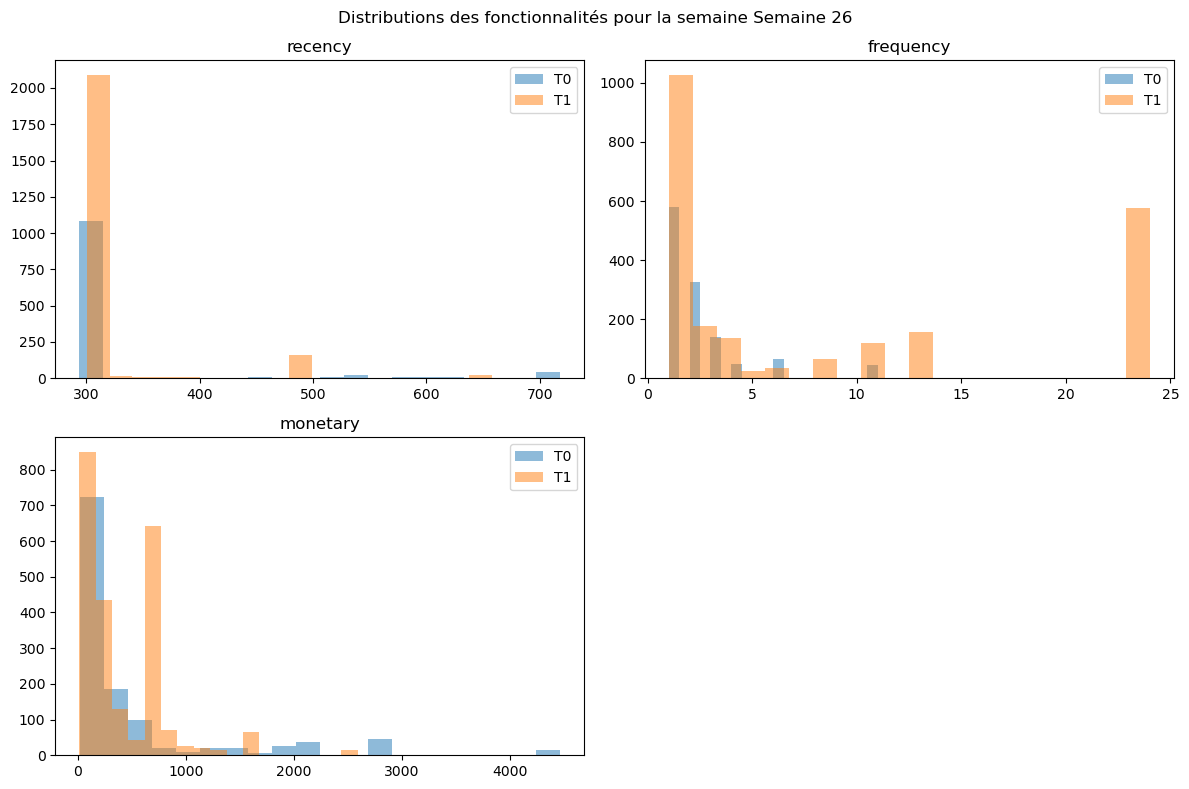

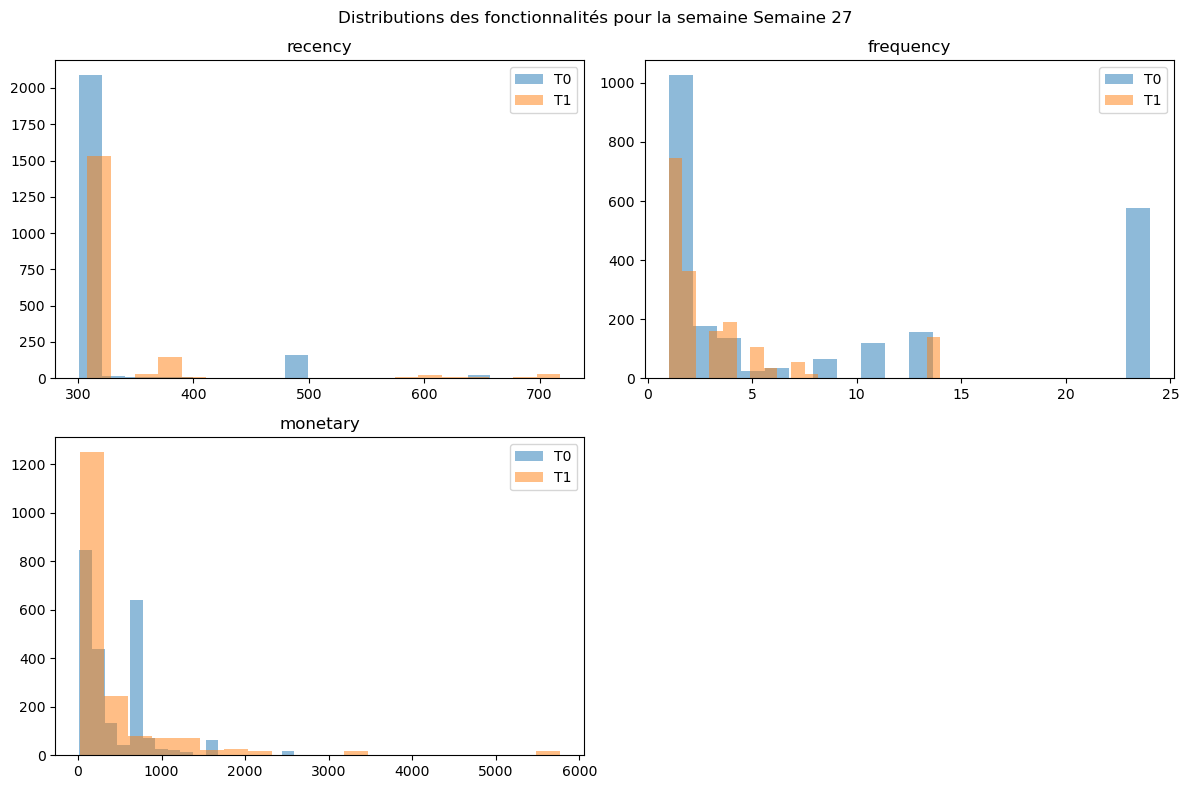

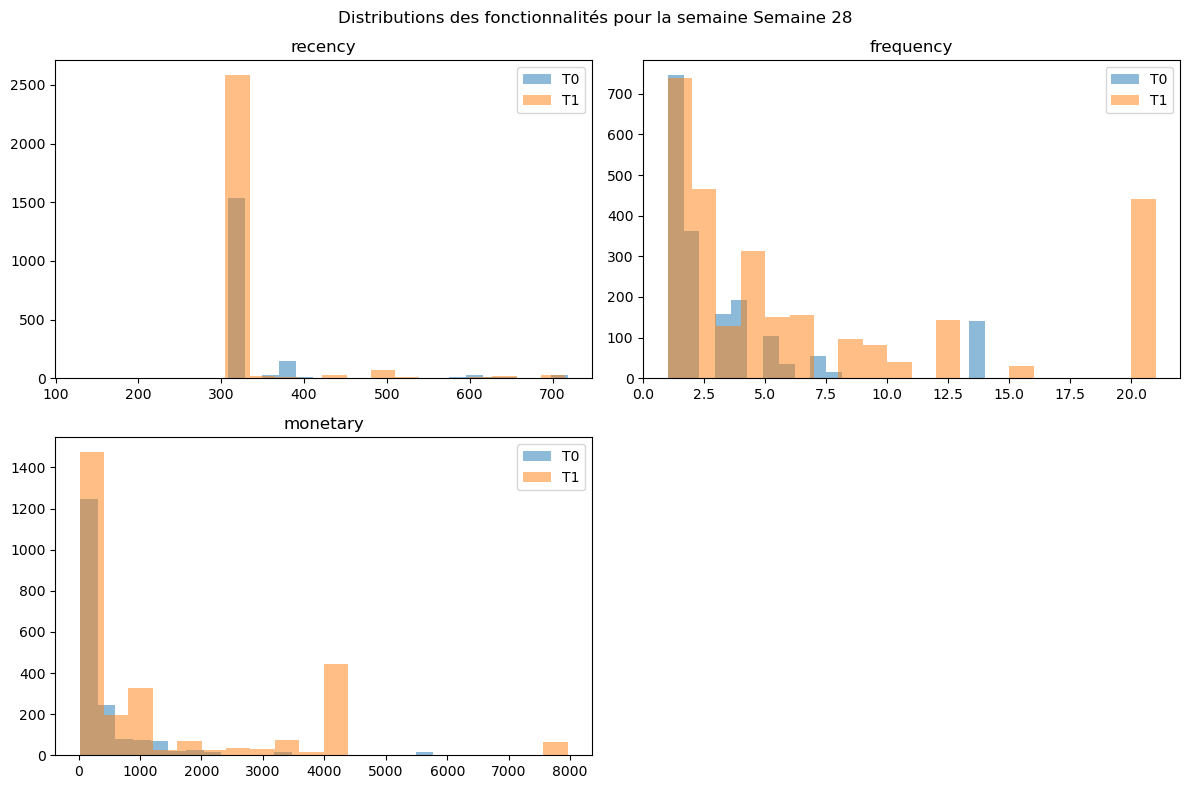

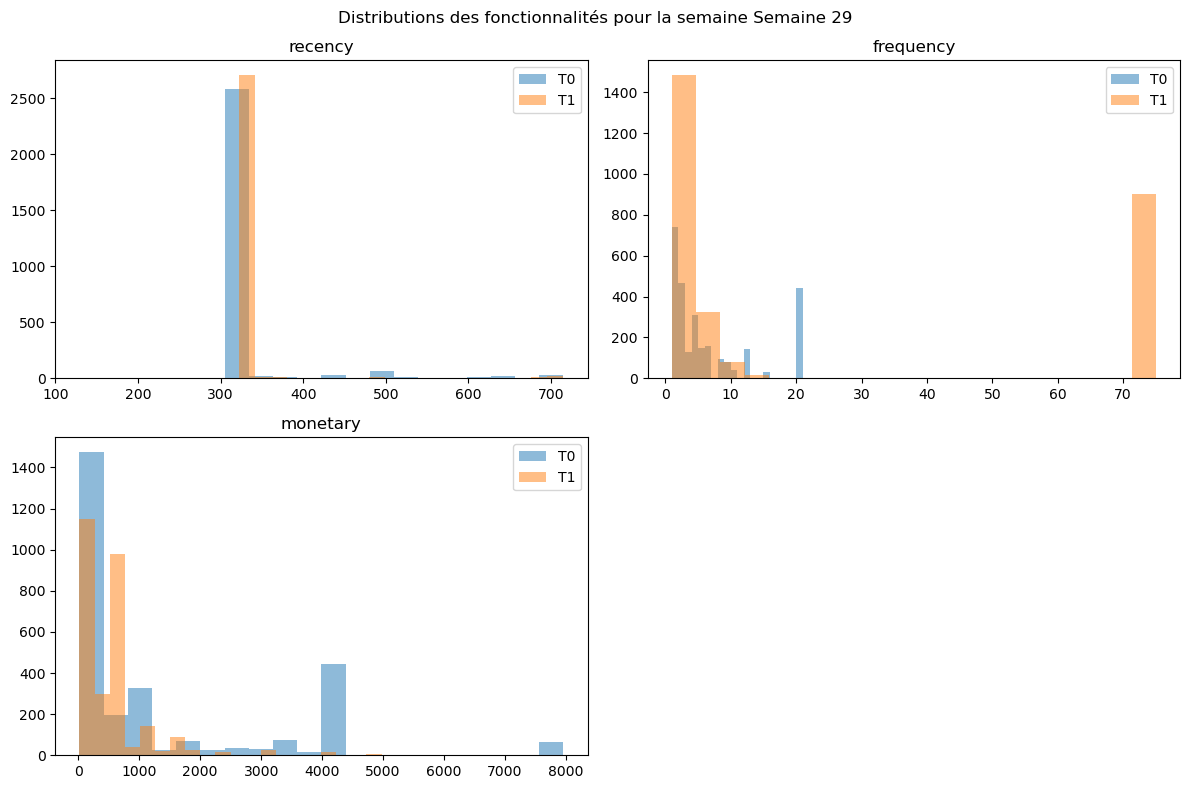

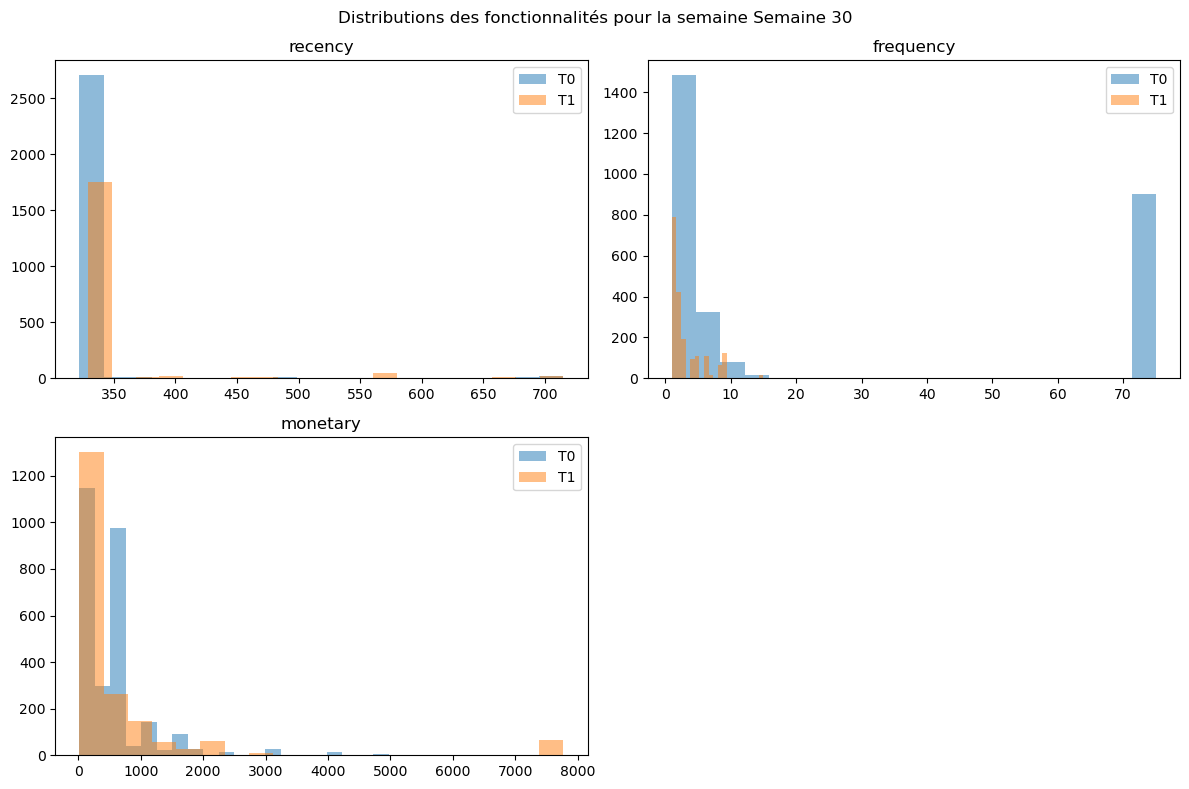

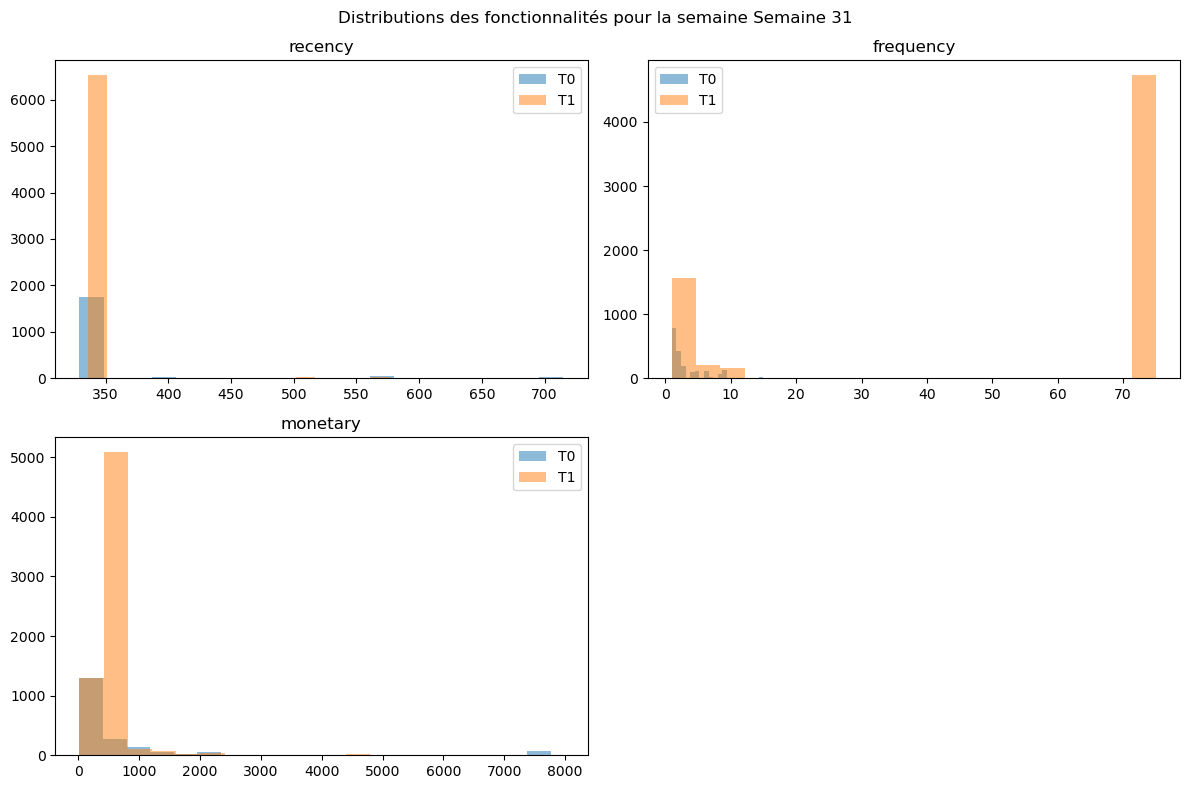

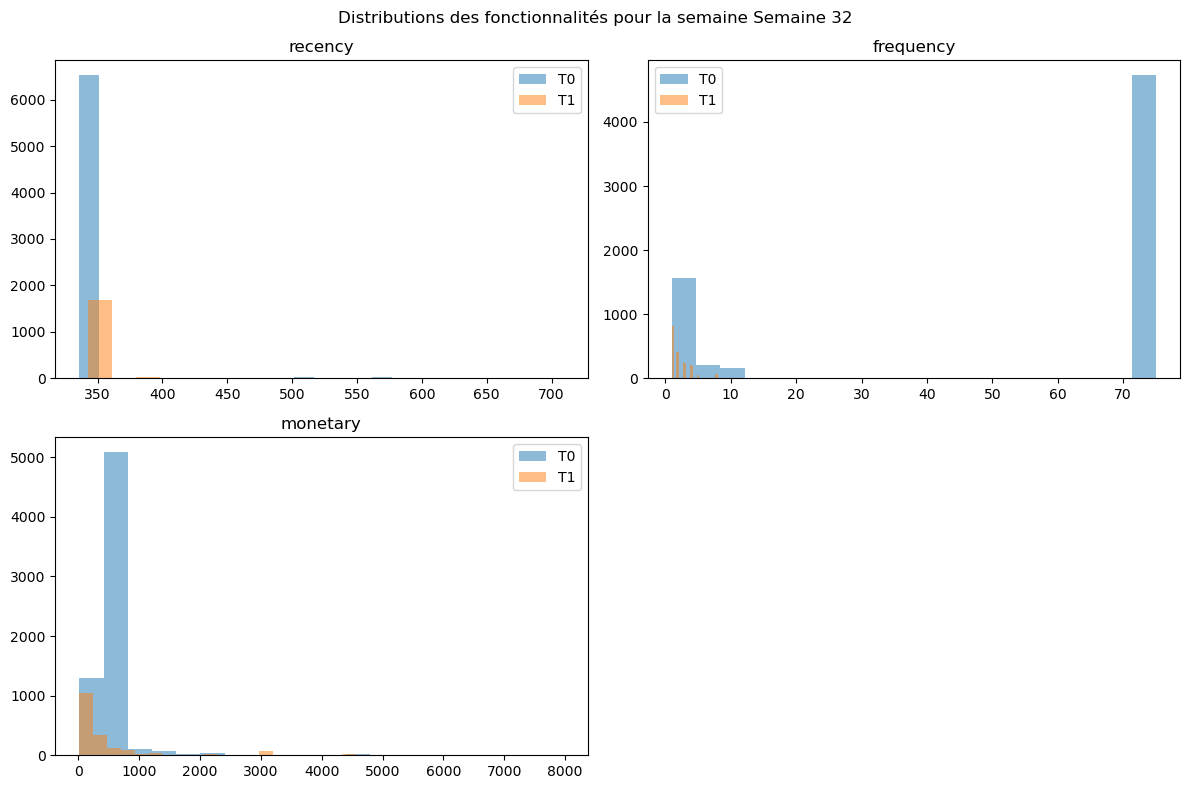

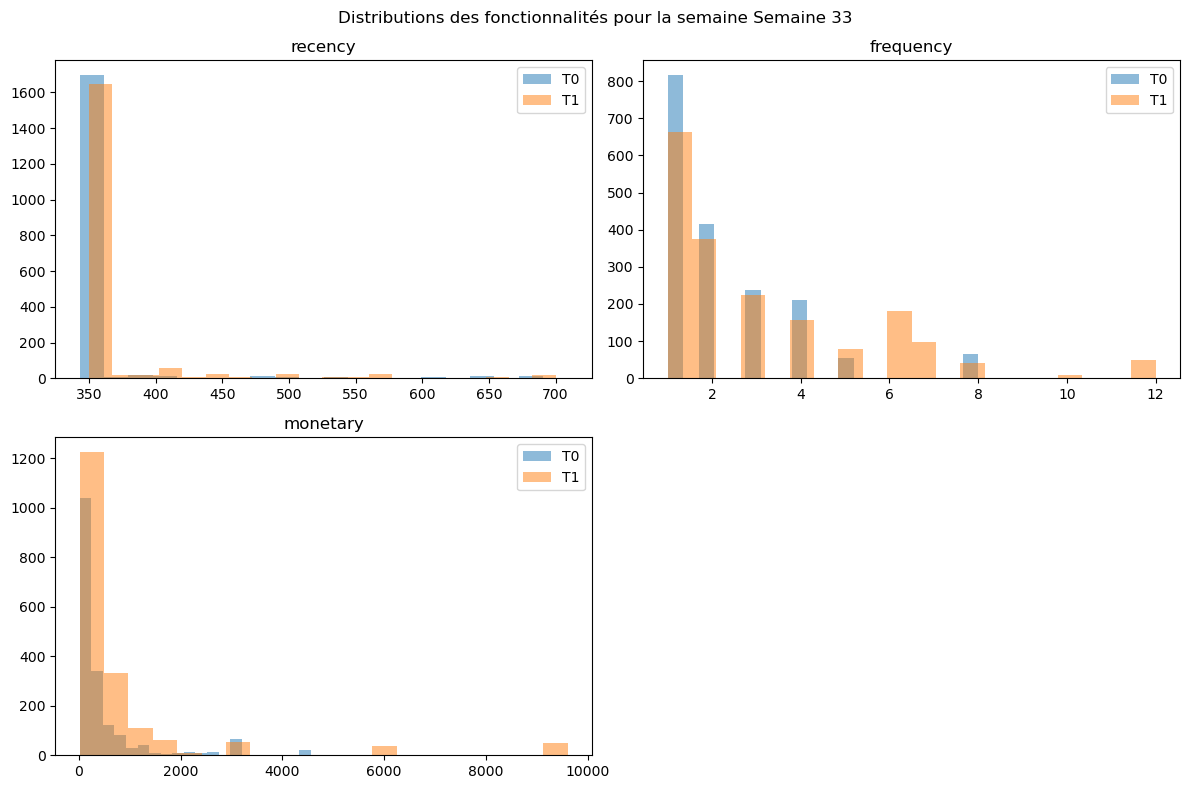

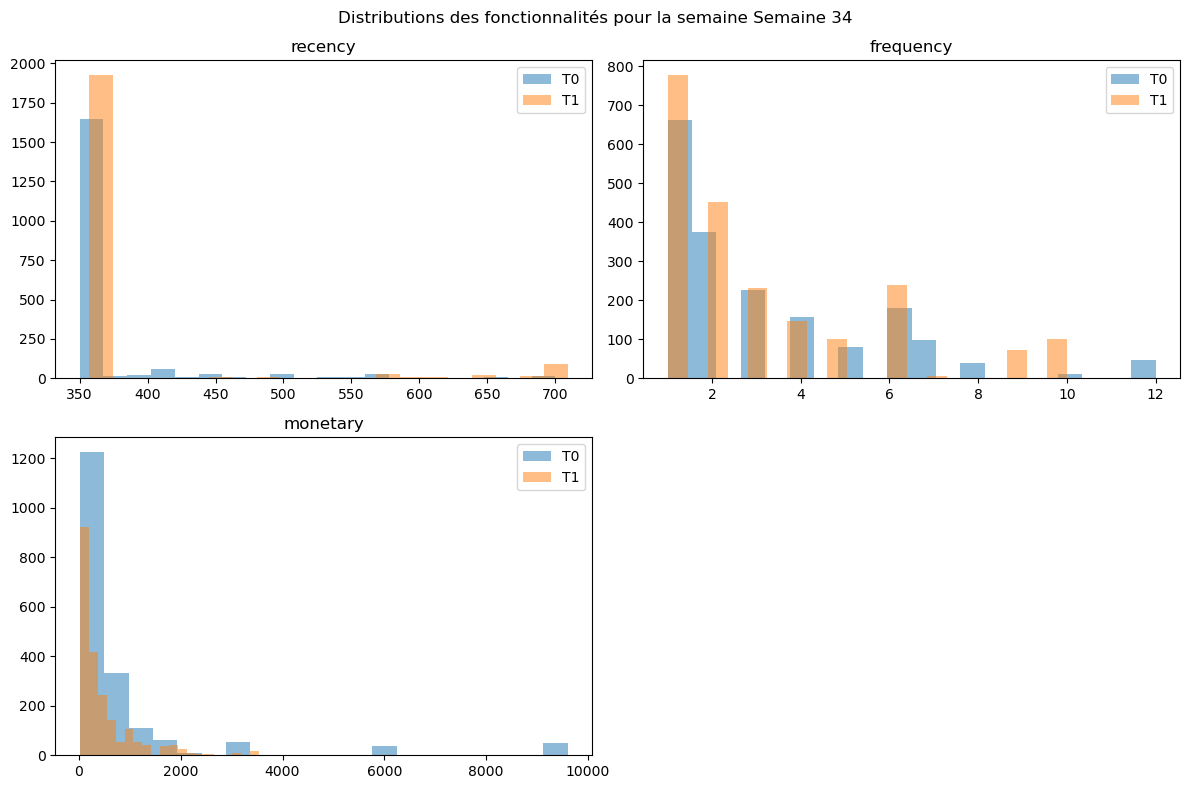

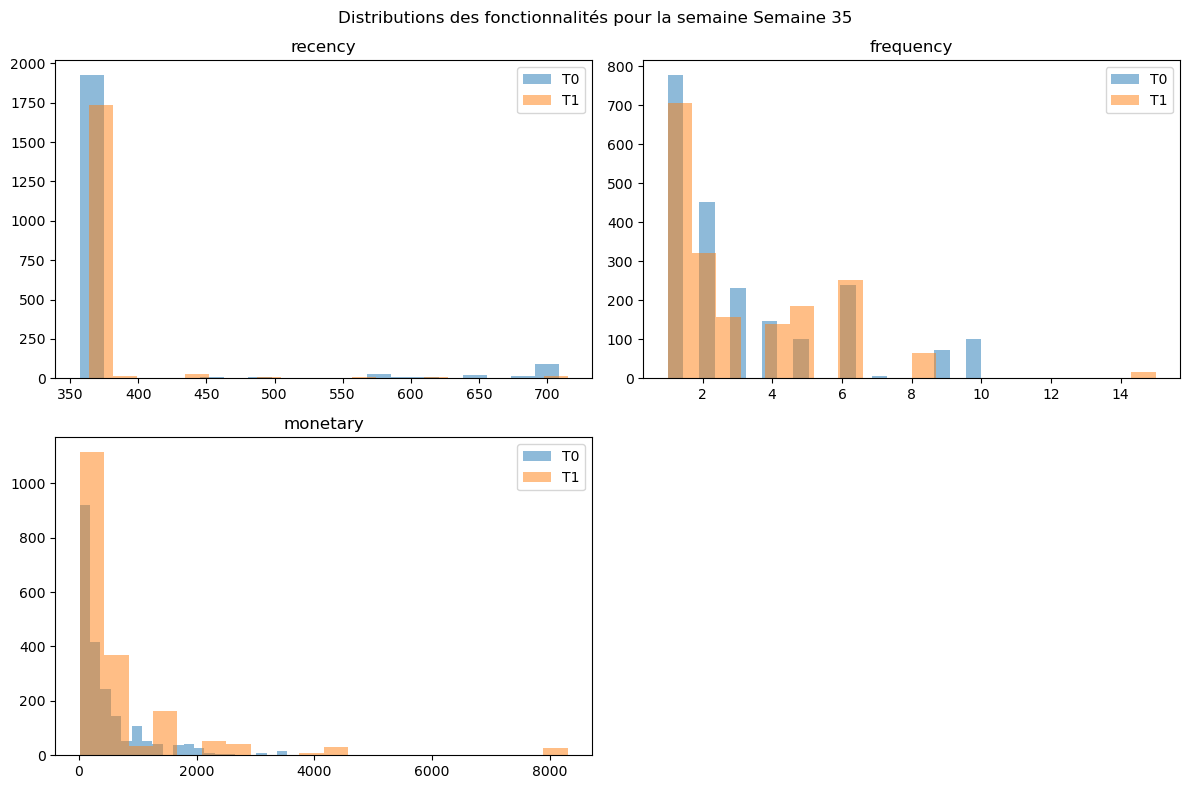

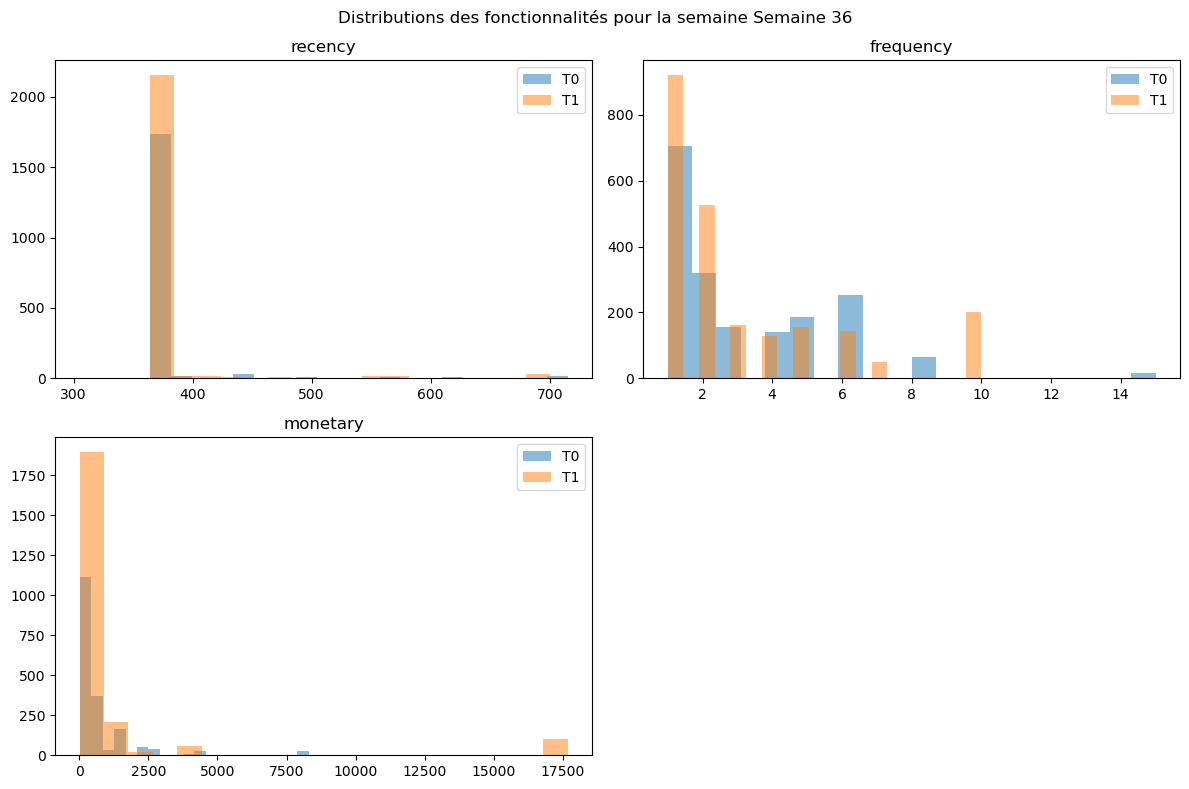

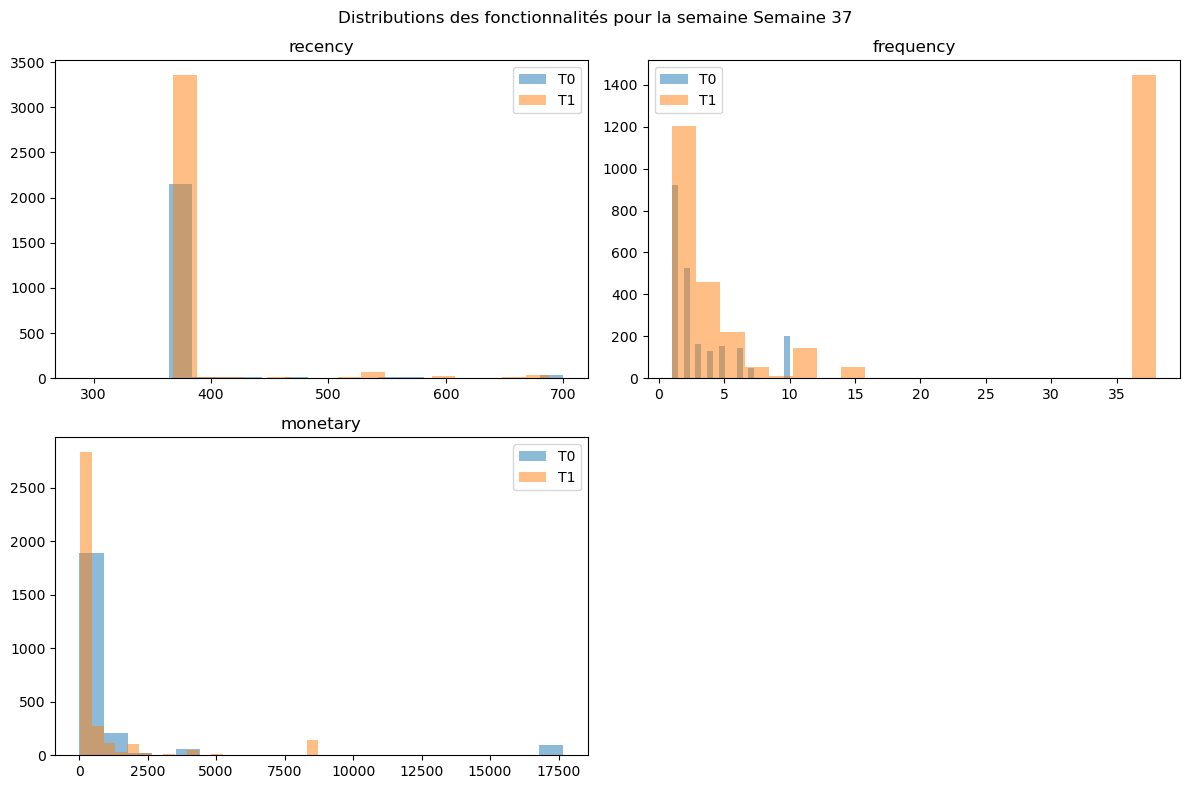

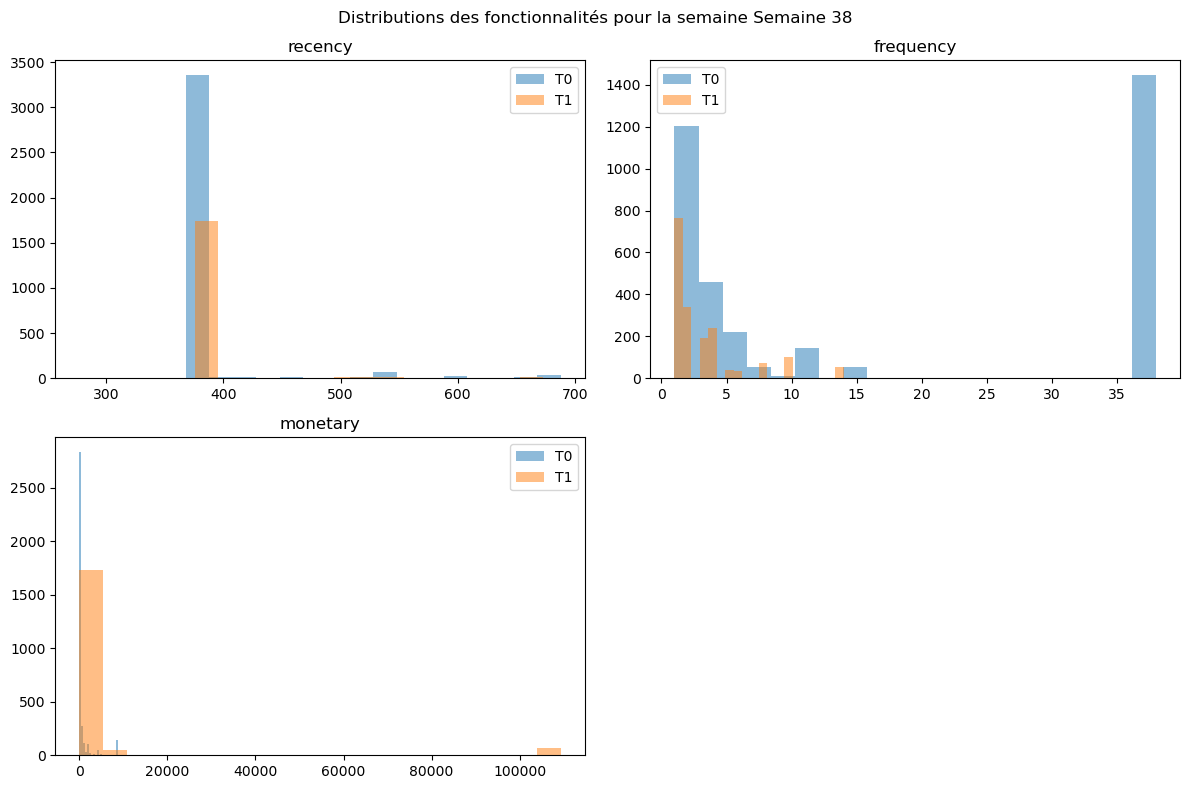

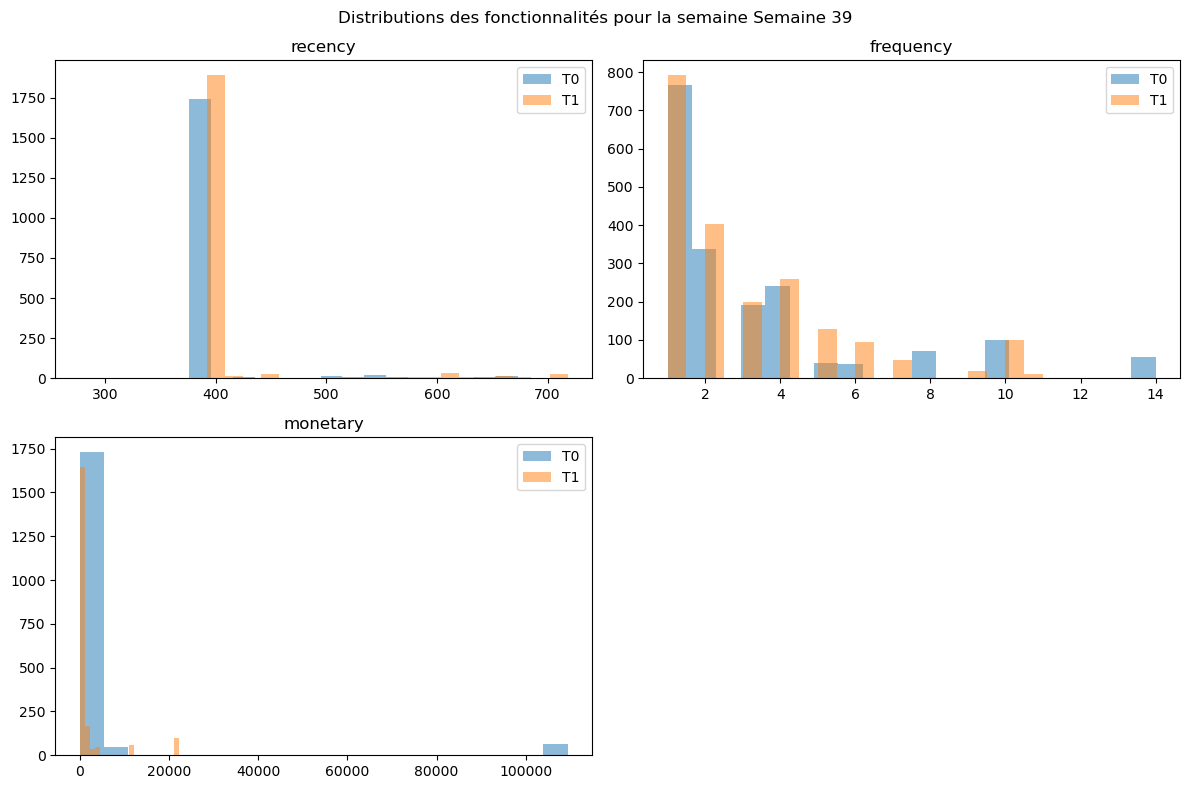

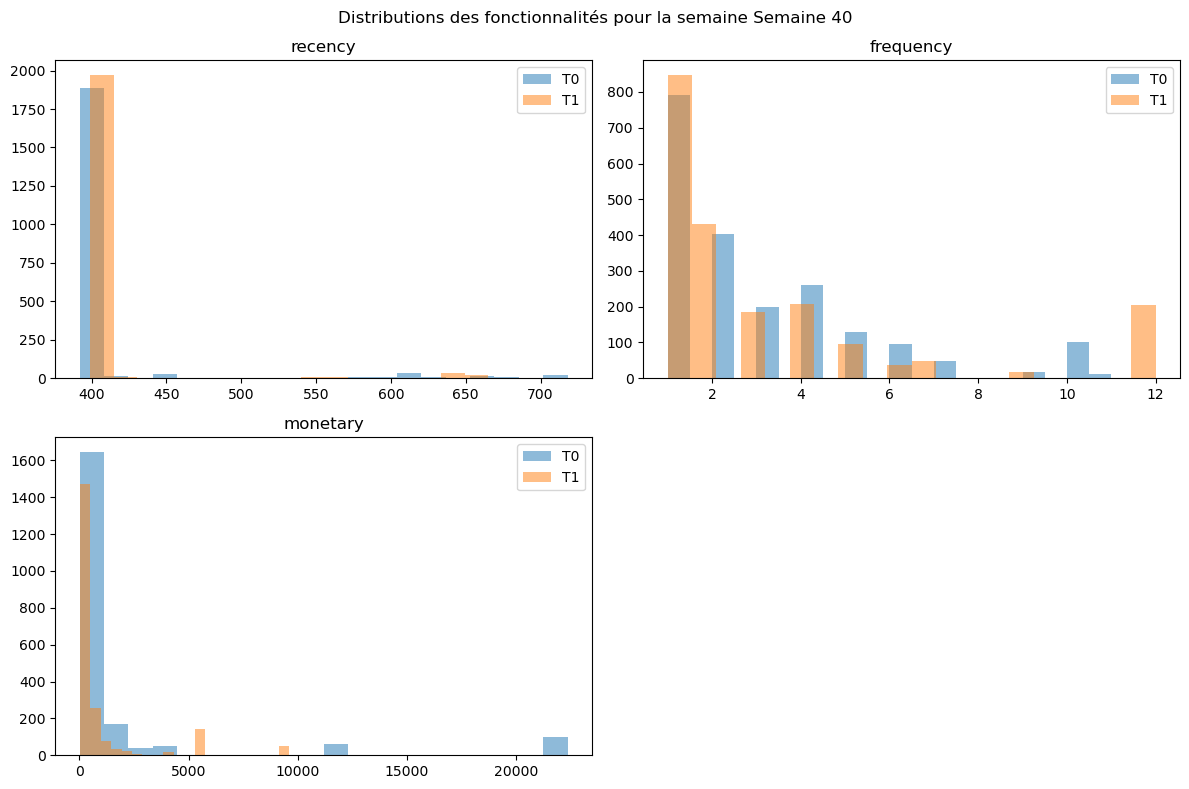

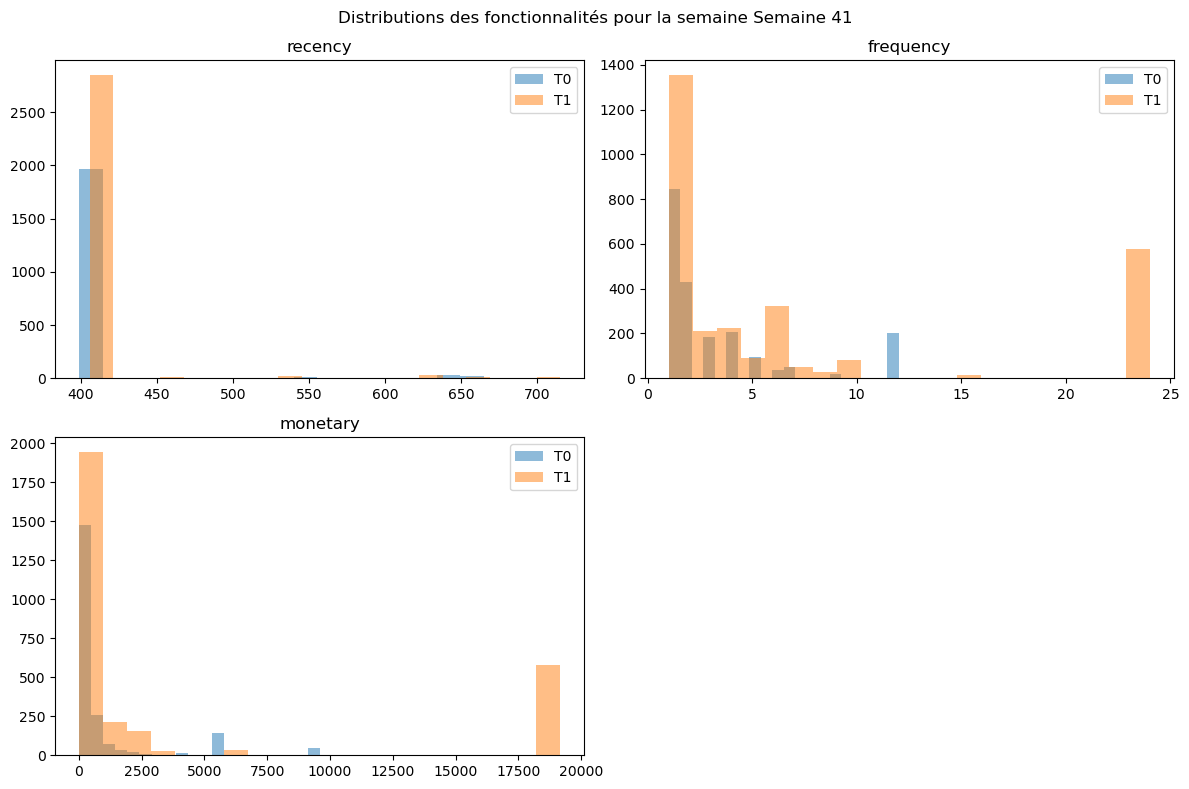

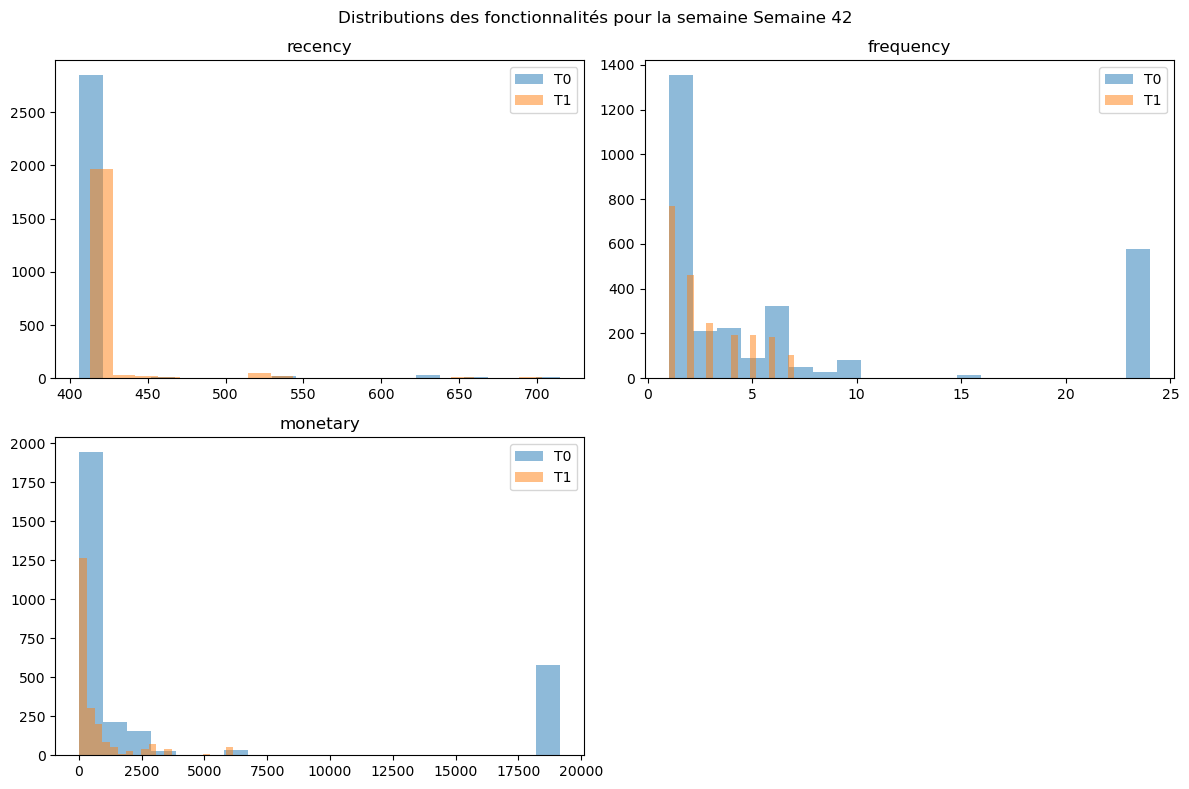

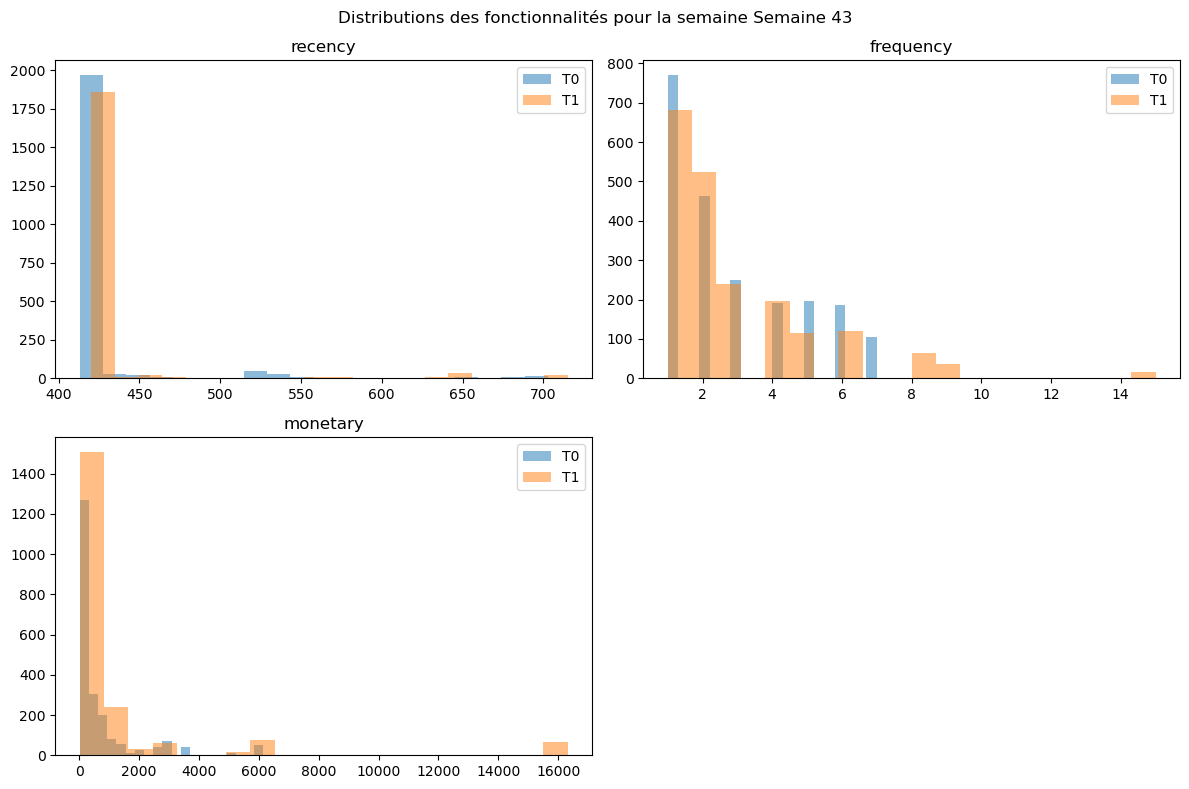

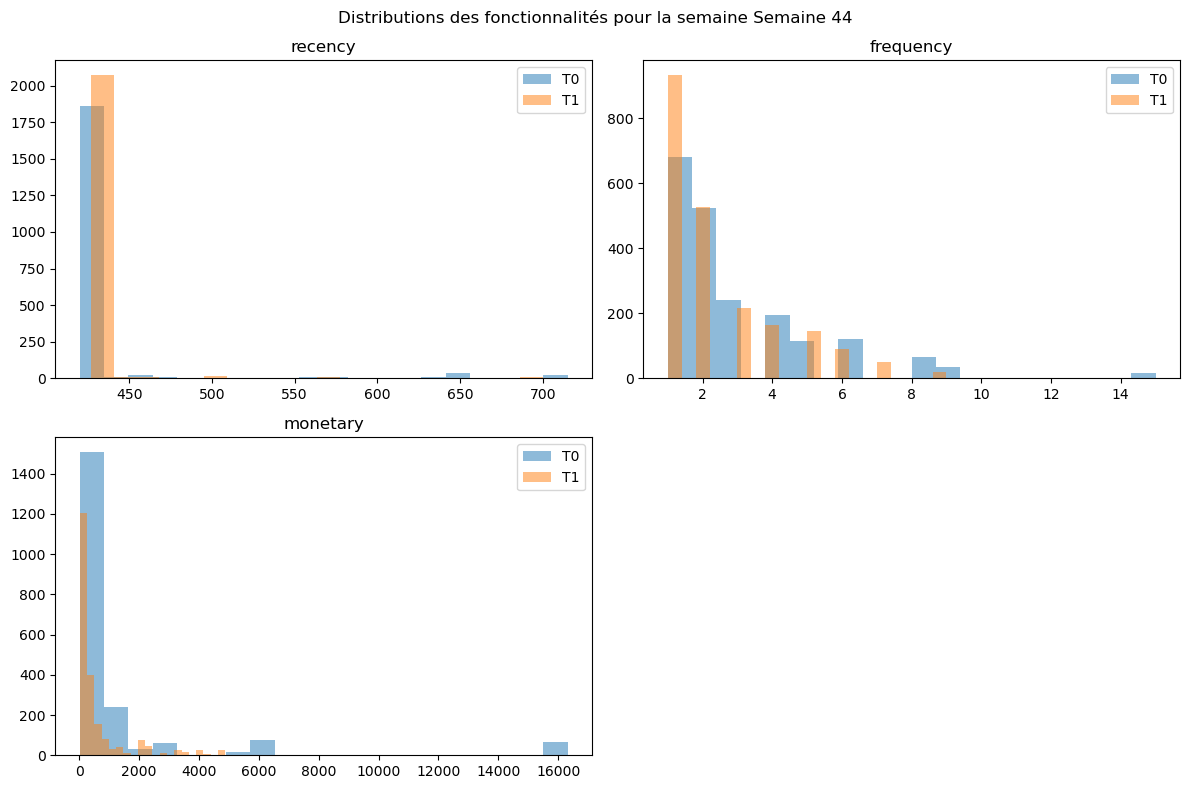

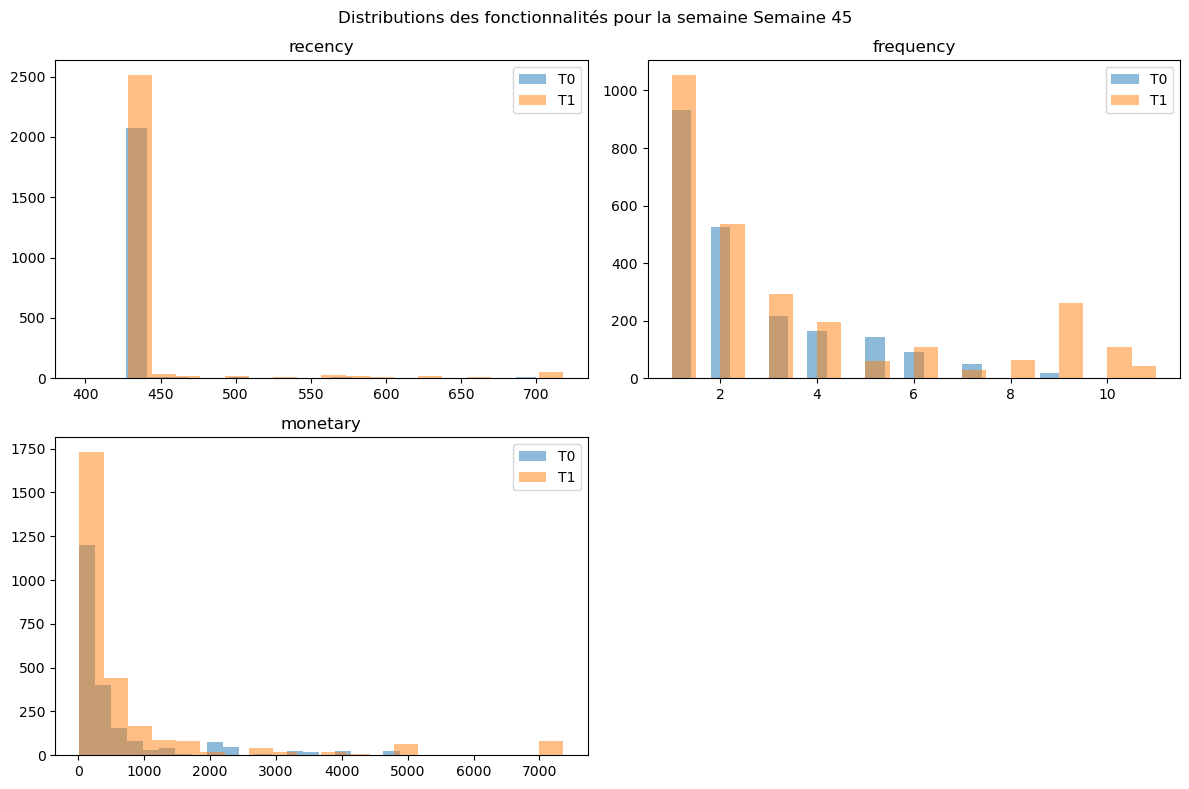

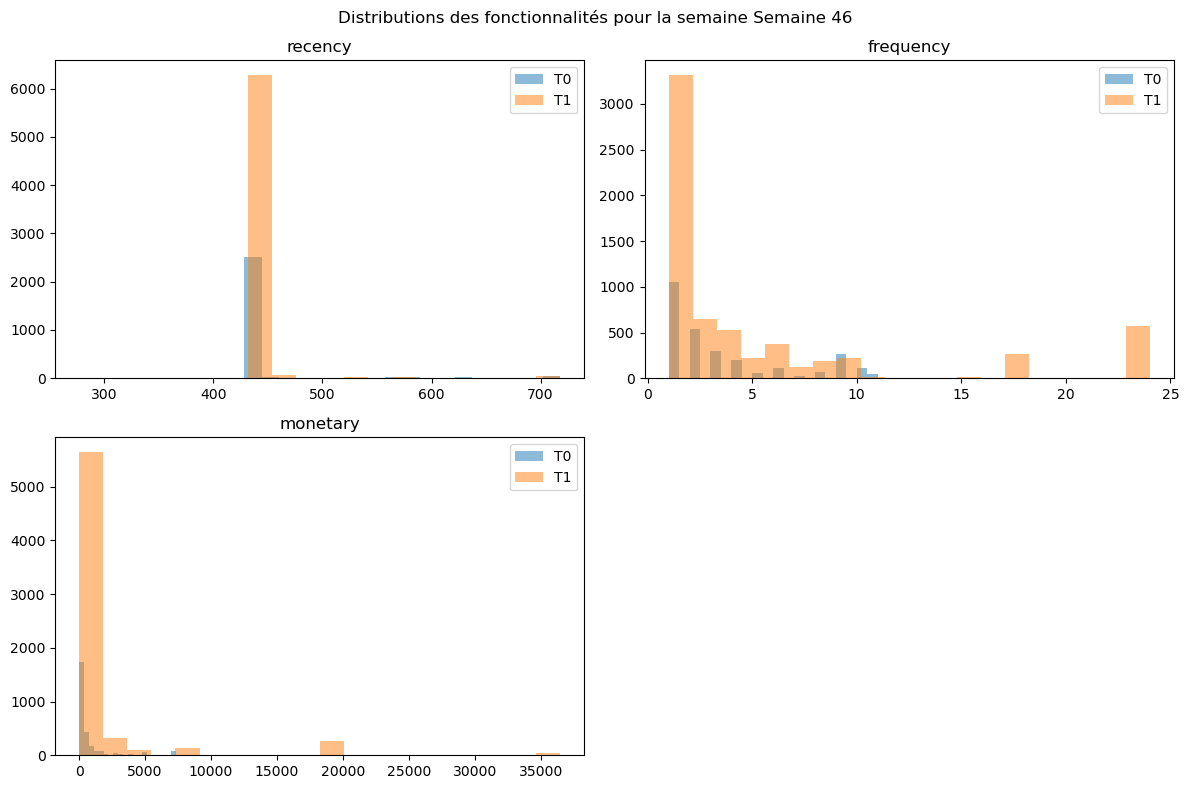

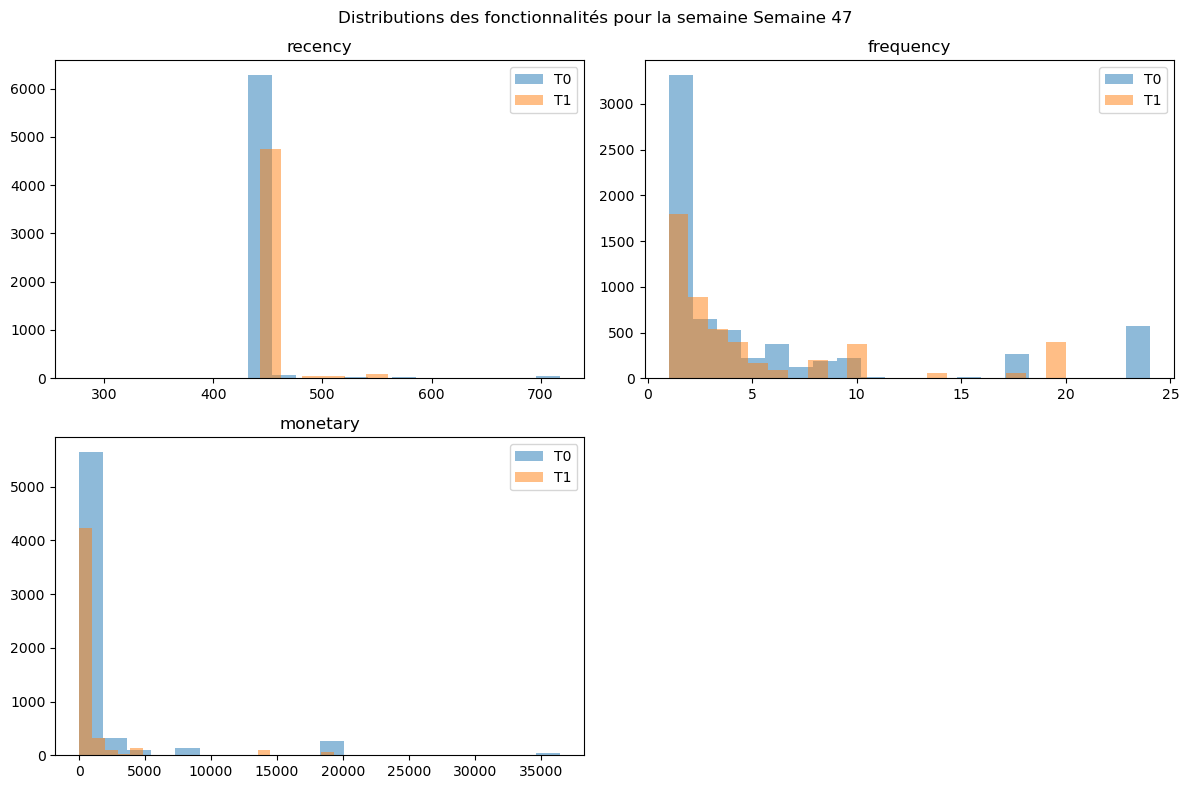

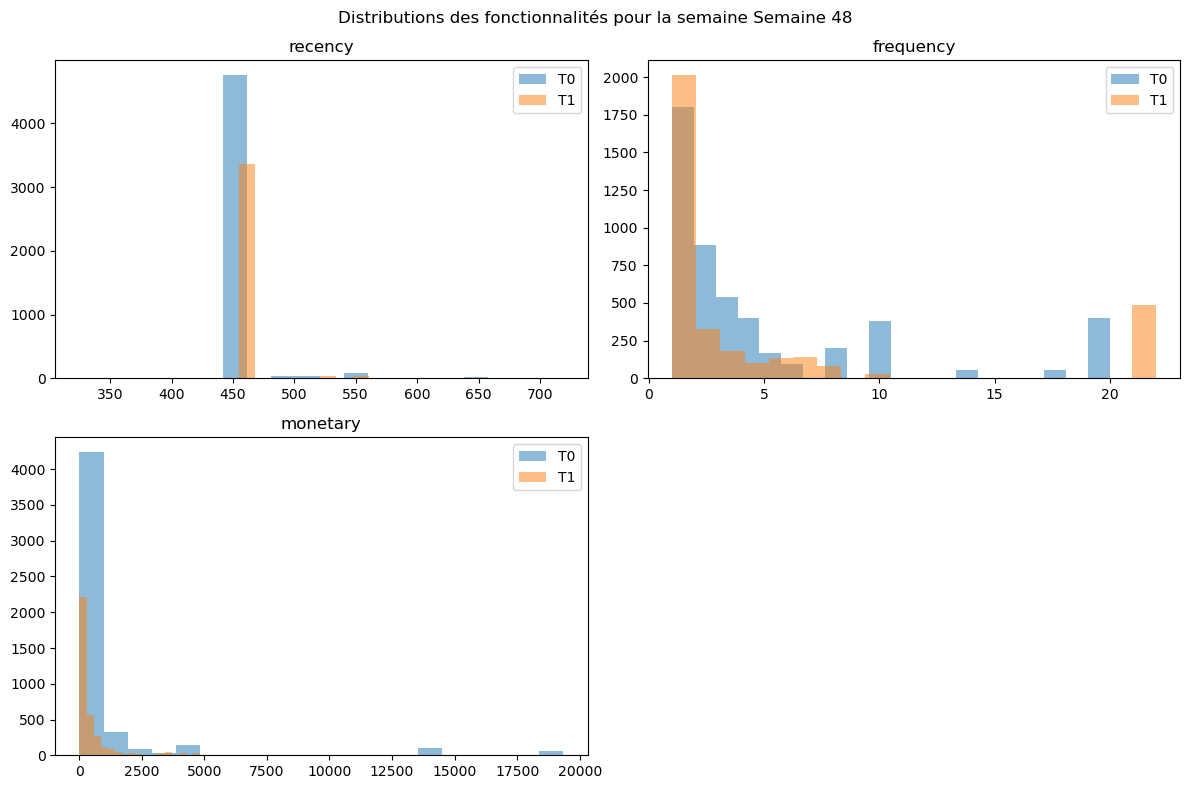

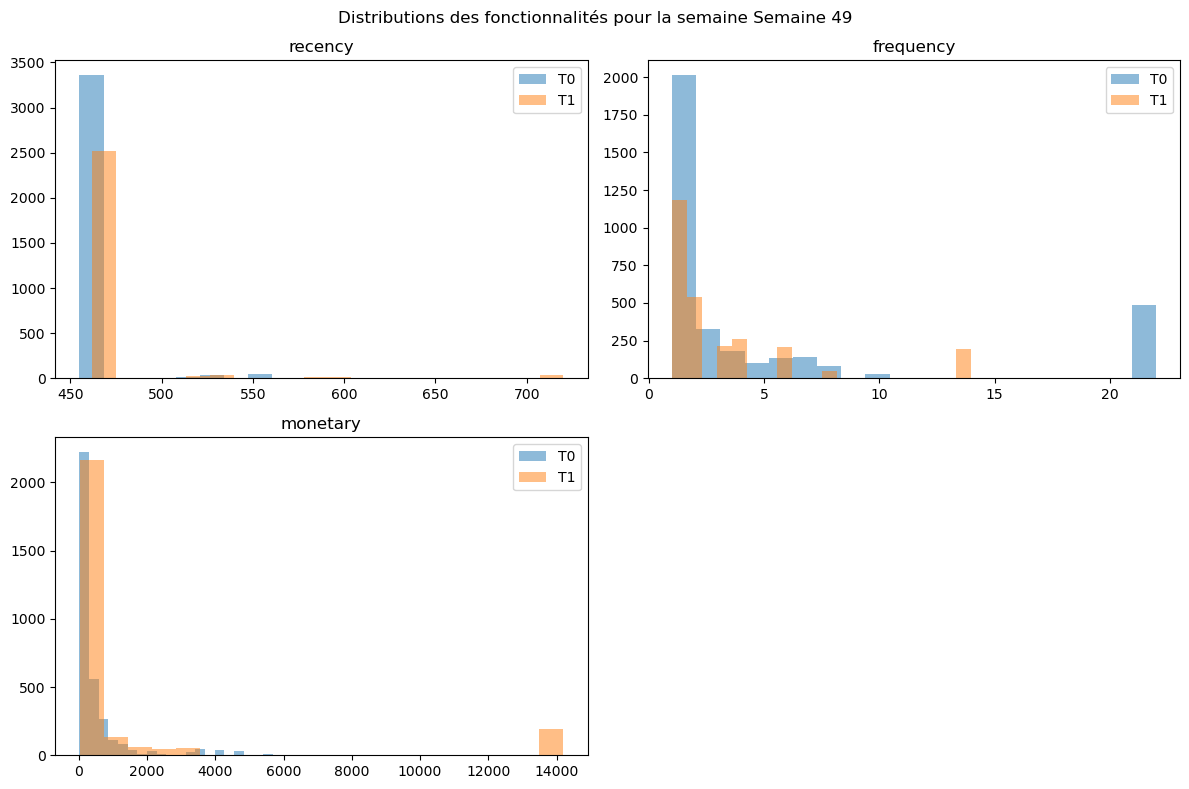

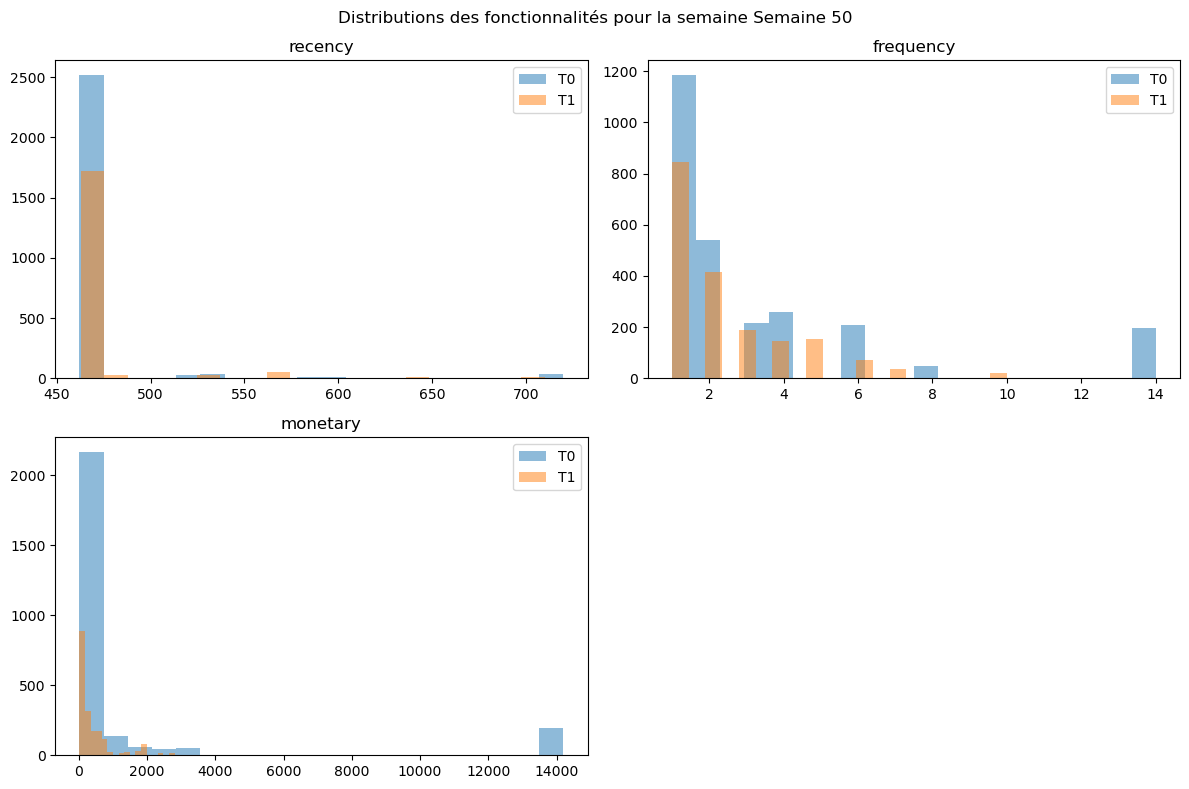

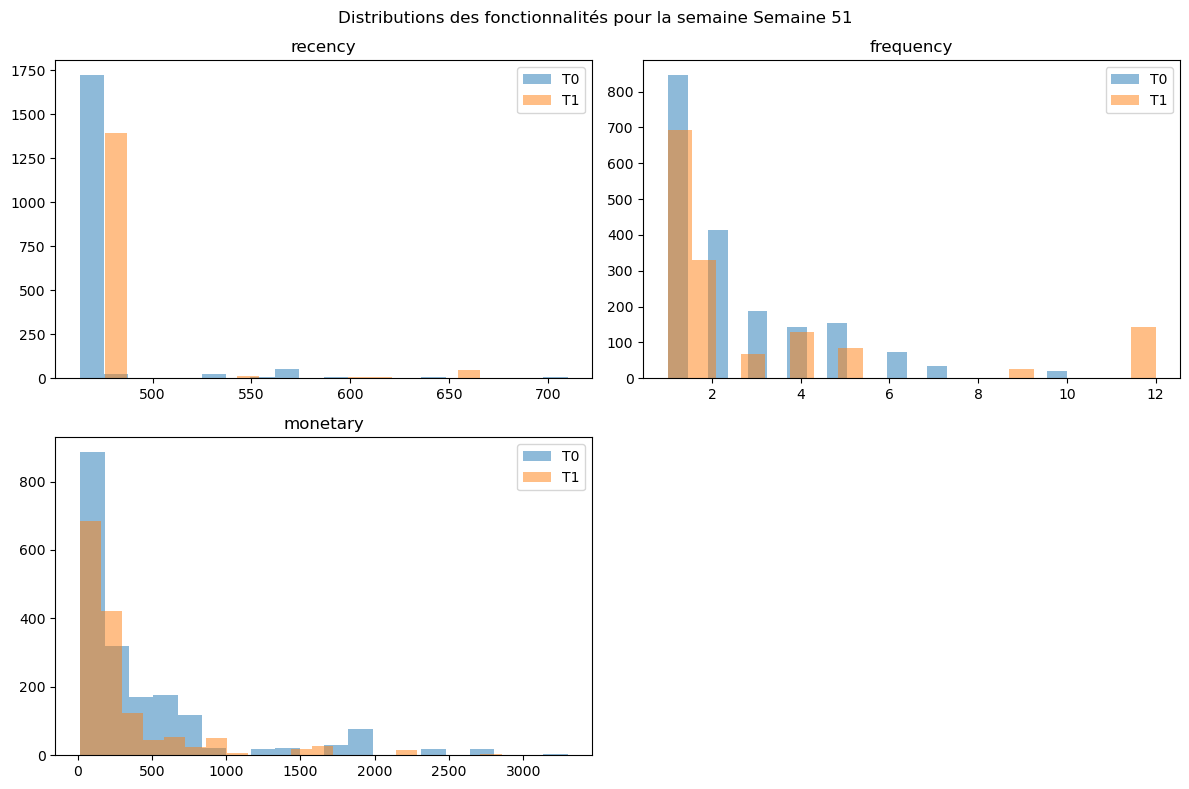

IndexError: list index out of range

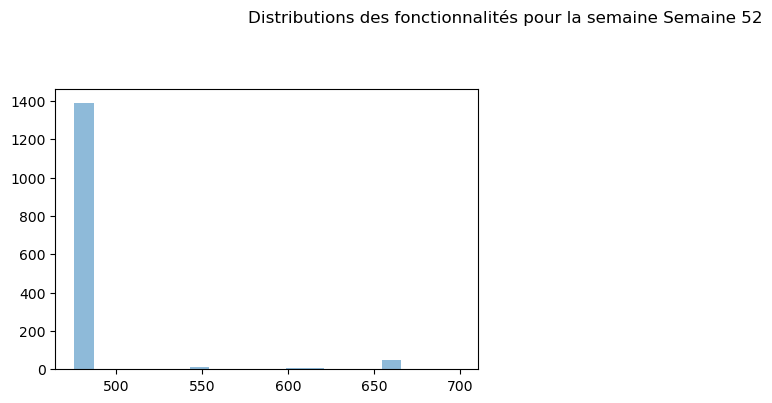

In [19]:
# Pour chaque semaine, afficher les histogrammes des fonctionnalités pour comparer visuellement les distributions
for i, (week, ks_results) in enumerate(results):
    plt.figure(figsize=(12, 8))
    plt.suptitle(f"Distributions des fonctionnalités pour la semaine {week}")
    
    for j, (feature, _, _) in enumerate(ks_results):
        plt.subplot(2, 2, j+1)
        plt.hist(weekly_data_T0[i][feature], bins=20, alpha=0.5, label='T0')
        plt.hist(weekly_data_T0[i+1][feature], bins=20, alpha=0.5, label='T1')
        plt.title(feature)
        plt.legend()
    
    plt.tight_layout()
    plt.show()